# Data Quality Validation: Raw → Preprocessed → Refined

Comprehensive analysis of text processing pipeline quality across 3 stages:
1. **Text Statistics**: Length, TTR, noise ratio, keyword density
2. **Embedding Quality**: Intra/inter-cluster distances, Silhouette Score
3. **Visual Comparison**: t-SNE & UMAP projections by stage
4. **Cross-lingual Alignment**: KR/EN convergence validation

In [20]:
# ===== Setup: Libraries & Paths =====
import os
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances
from umap import UMAP
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Data paths
DATA_DIR = "/Users/jeonghun/Algorithm-RAG-Engine/Evaluation_100/data"
IMG_DIR = "/Users/jeonghun/Algorithm-RAG-Engine/Evaluation_100/images"
os.makedirs(IMG_DIR, exist_ok=True)

BJ_RAW = f"{DATA_DIR}/baekjoon_raw_data.jsonl"
BJ_PREP = f"{DATA_DIR}/baekjoon_preprocessed.jsonl"
BJ_REF = f"{DATA_DIR}/baekjoon_refined.jsonl"

LC_RAW = f"{DATA_DIR}/leetcode_raw_data.jsonl"
LC_PREP = f"{DATA_DIR}/leetcode_preprocessed.jsonl"
LC_REF = f"{DATA_DIR}/leetcode_refined.jsonl"

GROUND_TRUTH = f"{DATA_DIR}/ground_truth_v2.json"

print("Libraries loaded")

Libraries loaded


In [21]:
# ===== Utility Functions =====

def load_jsonl(path):
    """Load JSONL file"""
    data = []
    try:
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    try:
                        data.append(json.loads(line))
                    except:
                        pass
    except:
        pass
    return data

def load_ground_truth():
    """Load algorithm type labels"""
    try:
        with open(GROUND_TRUTH, 'r', encoding='utf-8') as f:
            return json.load(f)
    except:
        return {}

def get_text(obj, field_candidates=("embedding_text", "content_cleaned", "content", "title")):
    """Extract best text field"""
    for field in field_candidates:
        if field in obj and isinstance(obj[field], str) and obj[field].strip():
            return obj[field]
    return ""

def strip_html(text):
    """Remove HTML tags"""
    return re.sub(r'<[^>]+>', ' ', text)

def calculate_ttr(text):
    """Type-Token Ratio (vocabulary diversity)"""
    words = text.lower().split()
    if not words:
        return 0.0
    return len(set(words)) / len(words)

def calculate_noise_ratio(text):
    """Ratio of HTML/numbers/special chars"""
    html_count = len(re.findall(r'<[^>]+>', text))
    number_count = len(re.findall(r'\d', text))
    special_count = len(re.findall(r'[^a-zA-Z0-9\s가-힣\n\.]', text))
    noise = html_count + number_count + special_count
    return noise / len(text) if text else 0.0

def calculate_keyword_density(text, keywords=None):
    """Calculate algorithm keyword density (keywords per 1000 chars)"""
    if keywords is None:
        keywords = [
            'algorithm', 'dynamic', 'dp', 'greedy', 'graph', 'tree', 'array',
            'sort', 'search', 'binary', 'depth', 'breadth', 'dfs', 'bfs',
            'hash', 'stack', 'queue', 'heap', 'recursion', 'backtrack',
            '알고리즘', '동적', '그리디', '그래프', '트리', '배열', '정렬',
            '탐색', '이진', '깊이', '너비', '재귀', '백트래킹'
        ]
    
    text_lower = text.lower()
    keyword_count = sum(text_lower.count(kw.lower()) for kw in keywords)
    
    # Return density per 1000 characters
    return (keyword_count / len(text) * 1000) if text else 0.0

def get_algorithm_type(problem_id, gt):
    """Get algorithm type from ground truth"""
    problem_key = f"BJ_{problem_id}" if "bj_" in problem_id.lower() else f"LC_{problem_id}"
    if problem_key in gt:
        tags = gt[problem_key].get("tag_inferred", [])
        return tags[0] if tags else "Unknown"
    return "Unknown"

# Load all data
print("Loading data...")
bj_raw = load_jsonl(BJ_RAW)
bj_prep = load_jsonl(BJ_PREP)
bj_ref = load_jsonl(BJ_REF)

lc_raw = load_jsonl(LC_RAW)
lc_prep = load_jsonl(LC_PREP)
lc_ref = load_jsonl(LC_REF)

gt = load_ground_truth()

print(f"Loaded: BJ({len(bj_raw)}/{len(bj_prep)}/{len(bj_ref)}), LC({len(lc_raw)}/{len(lc_prep)}/{len(lc_ref)})")

Loading data...
Loaded: BJ(100/100/100), LC(100/100/100)


## Stage 1: Text Statistics (Raw → Preprocessed → Refined)

In [22]:
# Stage 1: Calculate text statistics for all 3 stages
def compute_text_stats(datasets, names):
    """Compute metrics for each dataset"""
    stats = {name: {} for name in names}
    
    for name, data in zip(names, datasets):
        lengths = []
        ttrs = []
        noise_ratios = []
        keyword_densities = []
        
        for obj in data:
            text = get_text(obj)
            if text:
                lengths.append(len(text))
                ttrs.append(calculate_ttr(text))
                noise_ratios.append(calculate_noise_ratio(text))
                keyword_densities.append(calculate_keyword_density(text))
        
        stats[name] = {
            'lengths': lengths,
            'ttrs': ttrs,
            'noise_ratios': noise_ratios,
            'keyword_densities': keyword_densities,
            'avg_length': np.mean(lengths) if lengths else 0,
            'avg_ttr': np.mean(ttrs) if ttrs else 0,
            'avg_noise': np.mean(noise_ratios) if noise_ratios else 0,
            'avg_keyword_density': np.mean(keyword_densities) if keyword_densities else 0,
        }
    
    return stats

# Compute for Baekjoon & LeetCode
bj_stats_raw = compute_text_stats([bj_raw], ['BJ_Raw'])['BJ_Raw']
bj_stats_prep = compute_text_stats([bj_prep], ['BJ_Prep'])['BJ_Prep']
bj_stats_ref = compute_text_stats([bj_ref], ['BJ_Ref'])['BJ_Ref']

lc_stats_raw = compute_text_stats([lc_raw], ['LC_Raw'])['LC_Raw']
lc_stats_prep = compute_text_stats([lc_prep], ['LC_Prep'])['LC_Prep']
lc_stats_ref = compute_text_stats([lc_ref], ['LC_Ref'])['LC_Ref']

print("Text statistics computed")

Text statistics computed


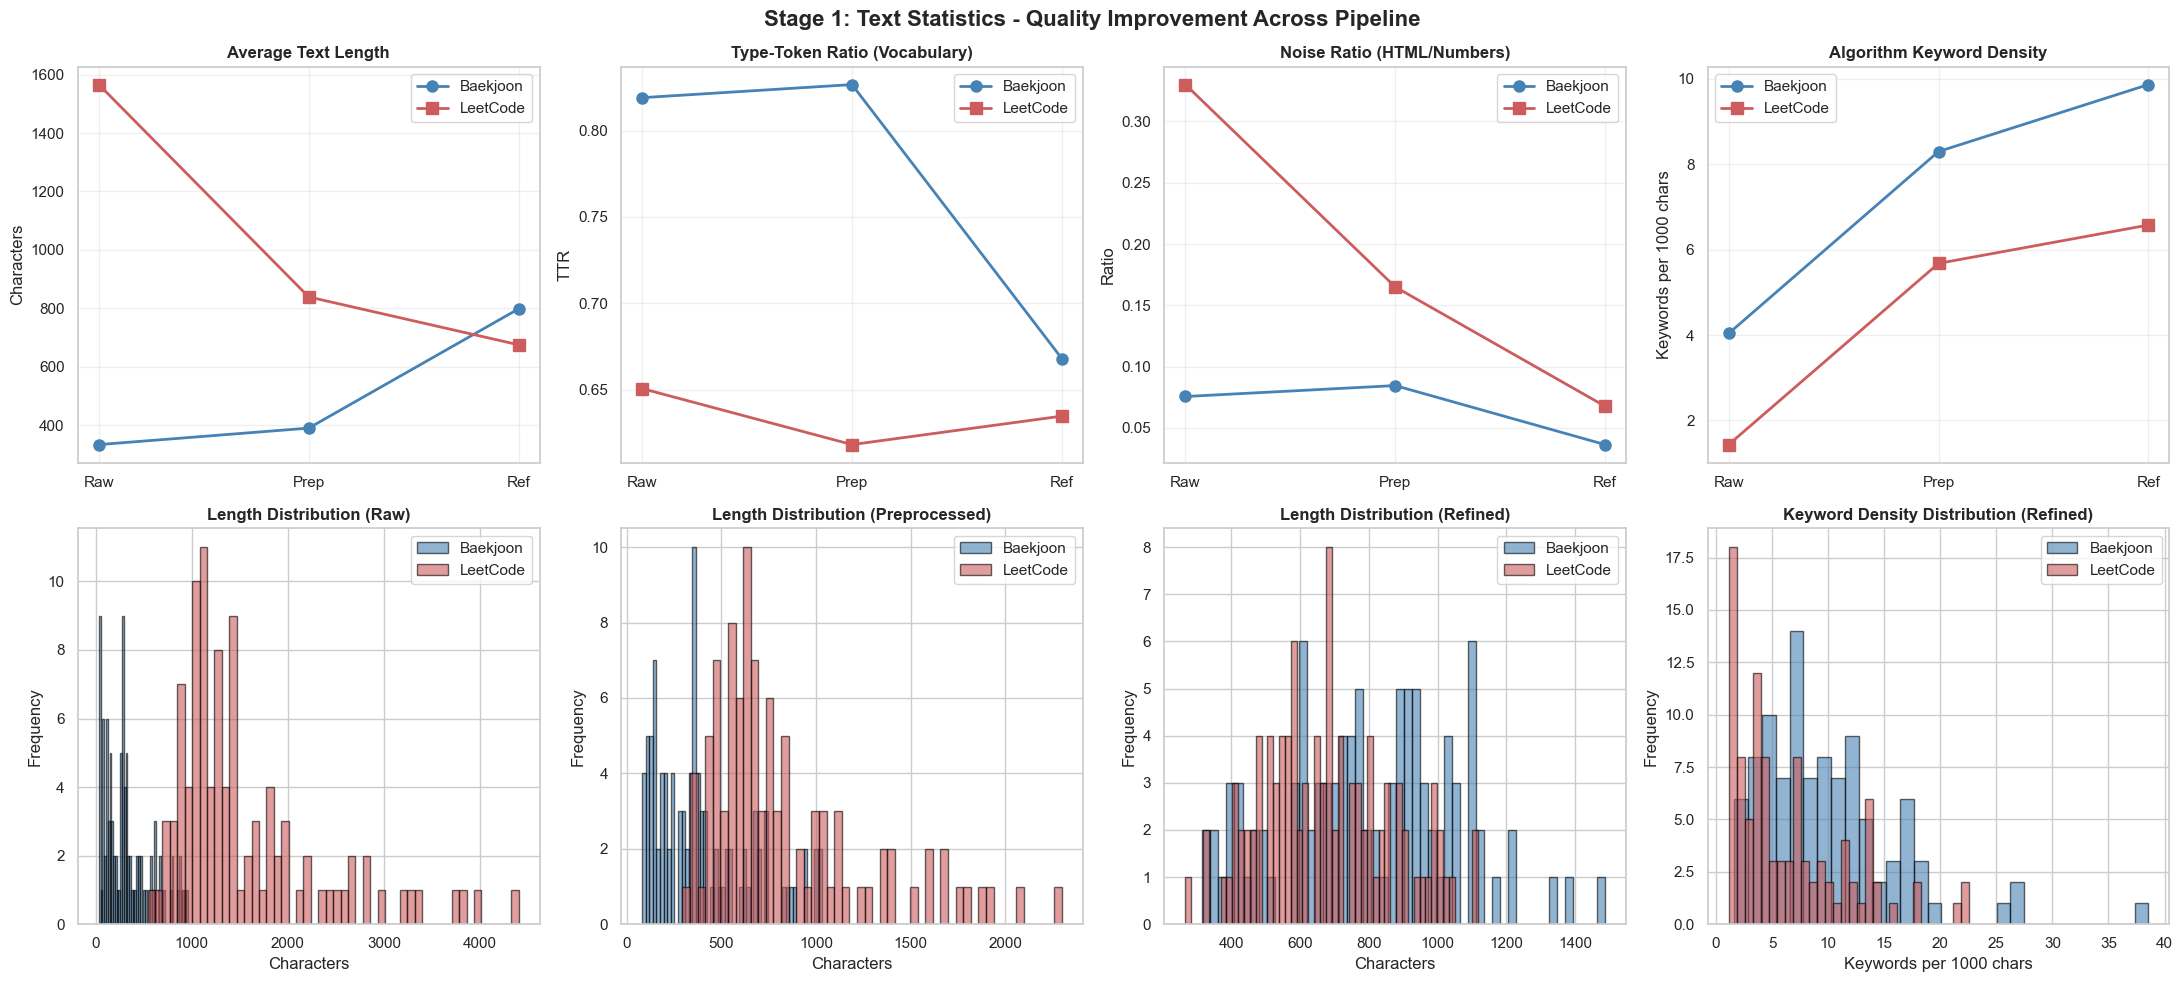

Stage 1 visualization saved


In [23]:
# Stage 1: Comprehensive Visualization
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle("Stage 1: Text Statistics - Quality Improvement Across Pipeline", fontsize=16, fontweight='bold')

# 1) Average Text Length Evolution
stages = ['Raw', 'Prep', 'Ref']
bj_lengths_avg = [bj_stats_raw['avg_length'], bj_stats_prep['avg_length'], bj_stats_ref['avg_length']]
lc_lengths_avg = [lc_stats_raw['avg_length'], lc_stats_prep['avg_length'], lc_stats_ref['avg_length']]

ax = axes[0, 0]
ax.plot(stages, bj_lengths_avg, 'o-', label='Baekjoon', linewidth=2, markersize=8, color='steelblue')
ax.plot(stages, lc_lengths_avg, 's-', label='LeetCode', linewidth=2, markersize=8, color='indianred')
ax.set_title("Average Text Length", fontweight='bold')
ax.set_ylabel("Characters")
ax.legend()
ax.grid(alpha=0.3)

# 2) Type-Token Ratio (Vocabulary Diversity)
bj_ttr_avg = [bj_stats_raw['avg_ttr'], bj_stats_prep['avg_ttr'], bj_stats_ref['avg_ttr']]
lc_ttr_avg = [lc_stats_raw['avg_ttr'], lc_stats_prep['avg_ttr'], lc_stats_ref['avg_ttr']]

ax = axes[0, 1]
ax.plot(stages, bj_ttr_avg, 'o-', label='Baekjoon', linewidth=2, markersize=8, color='steelblue')
ax.plot(stages, lc_ttr_avg, 's-', label='LeetCode', linewidth=2, markersize=8, color='indianred')
ax.set_title("Type-Token Ratio (Vocabulary)", fontweight='bold')
ax.set_ylabel("TTR")
ax.legend()
ax.grid(alpha=0.3)

# 3) Noise Ratio Reduction
bj_noise_avg = [bj_stats_raw['avg_noise'], bj_stats_prep['avg_noise'], bj_stats_ref['avg_noise']]
lc_noise_avg = [lc_stats_raw['avg_noise'], lc_stats_prep['avg_noise'], lc_stats_ref['avg_noise']]

ax = axes[0, 2]
ax.plot(stages, bj_noise_avg, 'o-', label='Baekjoon', linewidth=2, markersize=8, color='steelblue')
ax.plot(stages, lc_noise_avg, 's-', label='LeetCode', linewidth=2, markersize=8, color='indianred')
ax.set_title("Noise Ratio (HTML/Numbers)", fontweight='bold')
ax.set_ylabel("Ratio")
ax.legend()
ax.grid(alpha=0.3)

# 4) Algorithm Keyword Density
bj_keyword_avg = [bj_stats_raw['avg_keyword_density'], bj_stats_prep['avg_keyword_density'], bj_stats_ref['avg_keyword_density']]
lc_keyword_avg = [lc_stats_raw['avg_keyword_density'], lc_stats_prep['avg_keyword_density'], lc_stats_ref['avg_keyword_density']]

ax = axes[0, 3]
ax.plot(stages, bj_keyword_avg, 'o-', label='Baekjoon', linewidth=2, markersize=8, color='steelblue')
ax.plot(stages, lc_keyword_avg, 's-', label='LeetCode', linewidth=2, markersize=8, color='indianred')
ax.set_title("Algorithm Keyword Density", fontweight='bold')
ax.set_ylabel("Keywords per 1000 chars")
ax.legend()
ax.grid(alpha=0.3)

# 5-7) Length distributions for each stage
all_stages_data = [
    (bj_stats_raw['lengths'], lc_stats_raw['lengths'], 'Raw'),
    (bj_stats_prep['lengths'], lc_stats_prep['lengths'], 'Preprocessed'),
    (bj_stats_ref['lengths'], lc_stats_ref['lengths'], 'Refined'),
]

for idx, (bj_lens, lc_lens, stage_name) in enumerate(all_stages_data):
    ax = axes[1, idx]
    ax.hist(bj_lens, bins=50, alpha=0.6, label='Baekjoon', color='steelblue', edgecolor='black')
    ax.hist(lc_lens, bins=50, alpha=0.6, label='LeetCode', color='indianred', edgecolor='black')
    ax.set_title(f"Length Distribution ({stage_name})", fontweight='bold')
    ax.set_xlabel("Characters")
    ax.set_ylabel("Frequency")
    ax.legend()

# 8) Keyword density distribution for refined stage
ax = axes[1, 3]
ax.hist(bj_stats_ref['keyword_densities'], bins=30, alpha=0.6, label='Baekjoon', color='steelblue', edgecolor='black')
ax.hist(lc_stats_ref['keyword_densities'], bins=30, alpha=0.6, label='LeetCode', color='indianred', edgecolor='black')
ax.set_title("Keyword Density Distribution (Refined)", fontweight='bold')
ax.set_xlabel("Keywords per 1000 chars")
ax.set_ylabel("Frequency")
ax.legend()

plt.tight_layout()
plt.savefig(f"{IMG_DIR}/stage1_text_statistics.png", dpi=150, bbox_inches='tight')
plt.show()
print("Stage 1 visualization saved")

## Stage 2: Embedding Quality (Cluster Coherence & Silhouette Score)

In [37]:
# ===== DATA STRUCTURE INSPECTION =====
print("=" * 70)
print("DATA STRUCTURE VERIFICATION")
print("=" * 70)

# Check Baekjoon datasets
print("\nBAEKJOON DATASETS:")
if bj_raw:
    print(f"  Raw:         {len(bj_raw):3d} items | Fields: {list(bj_raw[0].keys())}")
if bj_prep:
    print(f"  Preprocessed: {len(bj_prep):3d} items | Fields: {list(bj_prep[0].keys())}")
if bj_ref:
    print(f"  Refined:      {len(bj_ref):3d} items | Fields: {list(bj_ref[0].keys())}")

# Check LeetCode datasets
print("\nLEETCODE DATASETS:")
if lc_raw:
    print(f"  Raw:         {len(lc_raw):3d} items | Fields: {list(lc_raw[0].keys())}")
if lc_prep:
    print(f"  Preprocessed: {len(lc_prep):3d} items | Fields: {list(lc_prep[0].keys())}")
if lc_ref:
    print(f"  Refined:      {len(lc_ref):3d} items | Fields: {list(lc_ref[0].keys())}")

DATA STRUCTURE VERIFICATION

BAEKJOON DATASETS:
  Raw:         100 items | Fields: ['id', 'title', 'difficulty', 'tags', 'content', 'embedding', 'embedding_model', 'embedding_dim', 'embedding_jina', 'embedding_jina_model', 'embedding_jina_dim', 'embedding_openai', 'embedding_openai_model', 'embedding_openai_dim']
  Preprocessed: 100 items | Fields: ['id', 'title', 'difficulty', 'tags', 'content', 'content_cleaned', 'embedding_text', 'embedding', 'embedding_model', 'embedding_dim', 'embedding_jina', 'embedding_jina_model', 'embedding_jina_dim', 'embedding_openai', 'embedding_openai_model', 'embedding_openai_dim']
  Refined:      100 items | Fields: ['id', 'title', 'difficulty', 'tags', 'content', 'content_cleaned', 'embedding_text', 'embedding', 'embedding_model', 'embedding_dim', 'embedding_jina', 'embedding_jina_model', 'embedding_jina_dim', 'embedding_openai', 'embedding_openai_model', 'embedding_openai_dim']

LEETCODE DATASETS:
  Raw:         100 items | Fields: ['id', 'title', 'tit

In [25]:
# ===== STAGE 2: EMBEDDING QUALITY SETUP =====
# Function definitions for embedding analysis

def load_embeddings(data):
    """
    Extract embedding vectors from data objects.
    Expects 'embedding' field with list of floats (768-1536D vectors).
    
    Args:
        data: List of problem objects from JSONL
        
    Returns:
        numpy array of embeddings or None if not found
    """
    embs = []
    for obj in data:
        if 'embedding' in obj and isinstance(obj['embedding'], list):
            embs.append(np.array(obj['embedding'], dtype=np.float32))
    return np.array(embs) if embs else None


def get_algorithm_clusters(data):
    """
    Extract algorithm type labels from problem tags for clustering.
    
    Args:
        data: List of problem objects
        
    Returns:
        List of algorithm type labels
    """
    labels = []
    for obj in data:
        tags = obj.get('tags', [])
        label = tags[0] if tags else 'Unknown'
        labels.append(label)
    return labels


def compute_cluster_metrics(embeddings, labels):
    """
    Compute clustering quality metrics:
    - Silhouette Score: Overall cluster quality (-1 to 1)
    - Intra-cluster distance: Compactness (lower is better)
    - Inter-cluster distance: Separation (higher is better)
    
    Args:
        embeddings: numpy array of embedding vectors
        labels: List of cluster labels
        
    Returns:
        Dictionary with metrics or None if insufficient data
    """
    if embeddings is None or len(embeddings) < 10:
        return None
    
    unique_labels = list(set(labels))
    label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
    label_indices = np.array([label_to_idx[lbl] for lbl in labels])
    
    # Silhouette Score
    try:
        sil_score = silhouette_score(embeddings, label_indices, 
                                     sample_size=min(1000, len(embeddings)))
    except:
        sil_score = 0.0
    
    # Intra & Inter-cluster distances
    distances = pairwise_distances(embeddings)
    intra_dists = []
    inter_dists = []
    
    for i in range(len(unique_labels)):
        cluster_mask = label_indices == i
        if np.sum(cluster_mask) > 1:
            intra = distances[cluster_mask][:, cluster_mask]
            intra_dists.extend(intra[np.triu_indices_from(intra, k=1)])
    
    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            mask_i = label_indices == i
            mask_j = label_indices == j
            inter = distances[mask_i][:, mask_j]
            inter_dists.extend(inter.flatten())
    
    return {
        'silhouette': sil_score,
        'intra_mean': np.mean(intra_dists) if intra_dists else 0,
        'intra_std': np.std(intra_dists) if intra_dists else 0,
        'inter_mean': np.mean(inter_dists) if inter_dists else 0,
        'inter_std': np.std(inter_dists) if inter_dists else 0,
        'intra_dists': intra_dists,
        'inter_dists': inter_dists,
    }


# ===== LOAD EMBEDDINGS & COMPUTE METRICS =====
print("\n[Stage 2] Loading embeddings...")
bj_emb_raw = load_embeddings(bj_raw)
bj_emb_prep = load_embeddings(bj_prep)
bj_emb_ref = load_embeddings(bj_ref)

lc_emb_raw = load_embeddings(lc_raw)
lc_emb_prep = load_embeddings(lc_prep)
lc_emb_ref = load_embeddings(lc_ref)

print(f"\n  Baekjoon embeddings: {bj_emb_raw.shape if bj_emb_raw is not None else 'None'} / "
      f"{bj_emb_prep.shape if bj_emb_prep is not None else 'None'} / "
      f"{bj_emb_ref.shape if bj_emb_ref is not None else 'None'}")
print(f"  LeetCode embeddings: {lc_emb_raw.shape if lc_emb_raw is not None else 'None'} / "
      f"{lc_emb_prep.shape if lc_emb_prep is not None else 'None'} / "
      f"{lc_emb_ref.shape if lc_emb_ref is not None else 'None'}")

# Get algorithm type labels
print("\n[Stage 2] Computing clustering metrics...")
bj_labels_raw = get_algorithm_clusters(bj_raw)
bj_labels_prep = get_algorithm_clusters(bj_prep)
bj_labels_ref = get_algorithm_clusters(bj_ref)

lc_labels_raw = get_algorithm_clusters(lc_raw)
lc_labels_prep = get_algorithm_clusters(lc_prep)
lc_labels_ref = get_algorithm_clusters(lc_ref)

# Compute metrics
bj_metrics_raw = compute_cluster_metrics(bj_emb_raw, bj_labels_raw)
bj_metrics_prep = compute_cluster_metrics(bj_emb_prep, bj_labels_prep)
bj_metrics_ref = compute_cluster_metrics(bj_emb_ref, bj_labels_ref)

lc_metrics_raw = compute_cluster_metrics(lc_emb_raw, lc_labels_raw)
lc_metrics_prep = compute_cluster_metrics(lc_emb_prep, lc_labels_prep)
lc_metrics_ref = compute_cluster_metrics(lc_emb_ref, lc_labels_ref)

print("Stage 2 setup complete")


[Stage 2] Loading embeddings...

  Baekjoon embeddings: (100, 384) / (100, 384) / (100, 384)
  LeetCode embeddings: (100, 384) / (100, 384) / (100, 384)

[Stage 2] Computing clustering metrics...
Stage 2 setup complete



[Stage 2] Generating visualizations...


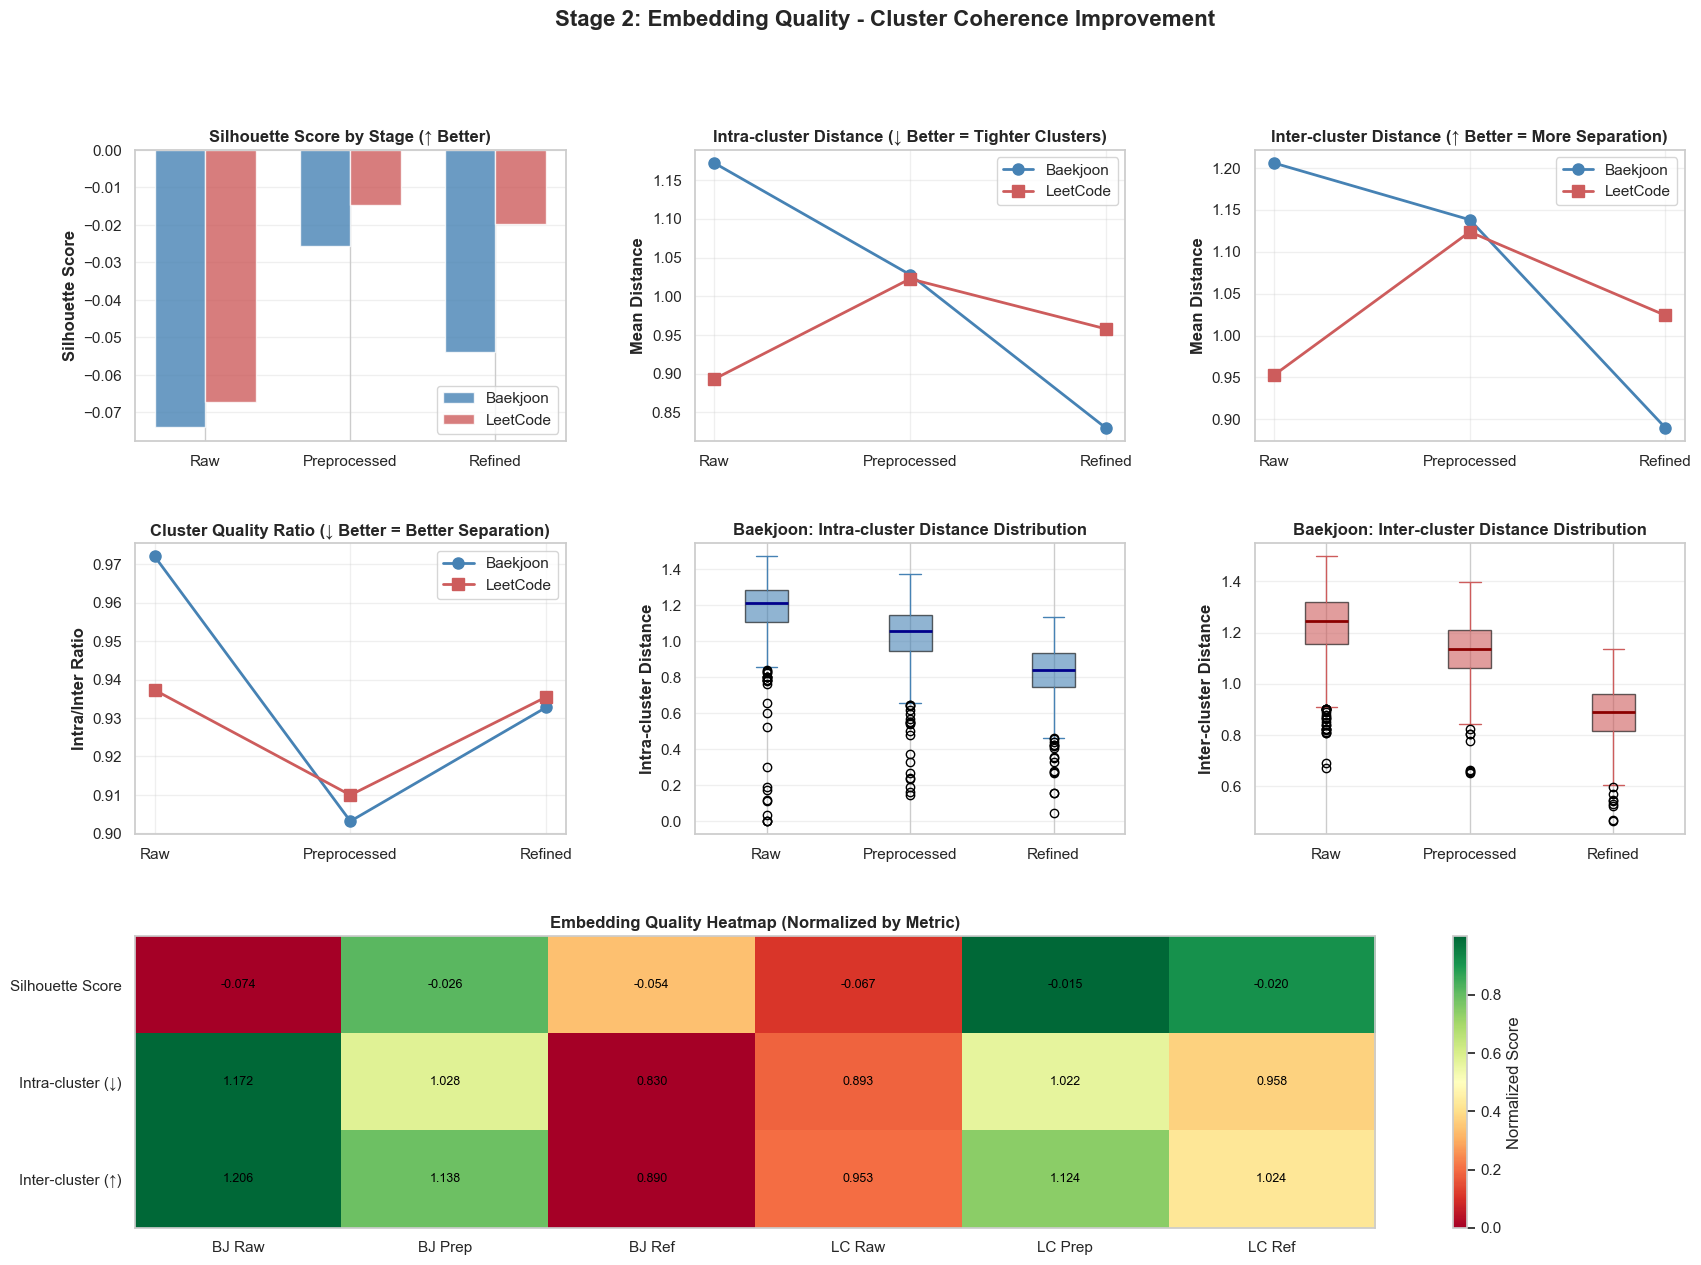

Stage 2 visualization saved


In [26]:
# ===== STAGE 2: EMBEDDING QUALITY VISUALIZATION =====
print("\n[Stage 2] Generating visualizations...")

# Check if embeddings are available for visualization
has_metrics = all(m is not None for m in [bj_metrics_raw, bj_metrics_prep, bj_metrics_ref, 
                                          lc_metrics_raw, lc_metrics_prep, lc_metrics_ref])

if has_metrics:
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    fig.suptitle("Stage 2: Embedding Quality - Cluster Coherence Improvement", 
                 fontsize=16, fontweight='bold')

    stages = ['Raw', 'Preprocessed', 'Refined']
    
    # Silhouette Scores across stages
    bj_silhouette = [bj_metrics_raw['silhouette'], bj_metrics_prep['silhouette'], bj_metrics_ref['silhouette']]
    lc_silhouette = [lc_metrics_raw['silhouette'], lc_metrics_prep['silhouette'], lc_metrics_ref['silhouette']]

    ax = fig.add_subplot(gs[0, 0])
    x = np.arange(len(stages))
    width = 0.35
    ax.bar(x - width/2, bj_silhouette, width, label='Baekjoon', color='steelblue', alpha=0.8)
    ax.bar(x + width/2, lc_silhouette, width, label='LeetCode', color='indianred', alpha=0.8)
    ax.set_ylabel('Silhouette Score', fontweight='bold')
    ax.set_title('Silhouette Score by Stage (↑ Better)', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(stages)
    ax.legend()
    ax.grid(alpha=0.3, axis='y')

    # Intra-cluster distance evolution
    bj_intra = [bj_metrics_raw['intra_mean'], bj_metrics_prep['intra_mean'], bj_metrics_ref['intra_mean']]
    lc_intra = [lc_metrics_raw['intra_mean'], lc_metrics_prep['intra_mean'], lc_metrics_ref['intra_mean']]

    ax = fig.add_subplot(gs[0, 1])
    ax.plot(stages, bj_intra, 'o-', label='Baekjoon', linewidth=2, markersize=8, color='steelblue')
    ax.plot(stages, lc_intra, 's-', label='LeetCode', linewidth=2, markersize=8, color='indianred')
    ax.set_ylabel('Mean Distance', fontweight='bold')
    ax.set_title('Intra-cluster Distance (↓ Better = Tighter Clusters)', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    # Inter-cluster distance evolution
    bj_inter = [bj_metrics_raw['inter_mean'], bj_metrics_prep['inter_mean'], bj_metrics_ref['inter_mean']]
    lc_inter = [lc_metrics_raw['inter_mean'], lc_metrics_prep['inter_mean'], lc_metrics_ref['inter_mean']]

    ax = fig.add_subplot(gs[0, 2])
    ax.plot(stages, bj_inter, 'o-', label='Baekjoon', linewidth=2, markersize=8, color='steelblue')
    ax.plot(stages, lc_inter, 's-', label='LeetCode', linewidth=2, markersize=8, color='indianred')
    ax.set_ylabel('Mean Distance', fontweight='bold')
    ax.set_title('Inter-cluster Distance (↑ Better = More Separation)', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    # Intra/Inter ratio (cluster quality)
    def safe_div(a, b):
        return a / b if b > 0 else 0

    bj_ratio = [safe_div(bj_metrics_raw['intra_mean'], bj_metrics_raw['inter_mean']),
                safe_div(bj_metrics_prep['intra_mean'], bj_metrics_prep['inter_mean']),
                safe_div(bj_metrics_ref['intra_mean'], bj_metrics_ref['inter_mean'])]
    lc_ratio = [safe_div(lc_metrics_raw['intra_mean'], lc_metrics_raw['inter_mean']),
                safe_div(lc_metrics_prep['intra_mean'], lc_metrics_prep['inter_mean']),
                safe_div(lc_metrics_ref['intra_mean'], lc_metrics_ref['inter_mean'])]

    ax = fig.add_subplot(gs[1, 0])
    ax.plot(stages, bj_ratio, 'o-', label='Baekjoon', linewidth=2, markersize=8, color='steelblue')
    ax.plot(stages, lc_ratio, 's-', label='LeetCode', linewidth=2, markersize=8, color='indianred')
    ax.set_ylabel('Intra/Inter Ratio', fontweight='bold')
    ax.set_title('Cluster Quality Ratio (↓ Better = Better Separation)', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    # BOX PLOTS: Intra-cluster distance distribution by stage
    ax = fig.add_subplot(gs[1, 1])
    box_data = [
        bj_metrics_raw['intra_dists'][:1000] if len(bj_metrics_raw['intra_dists']) > 0 else [],
        bj_metrics_prep['intra_dists'][:1000] if len(bj_metrics_prep['intra_dists']) > 0 else [],
        bj_metrics_ref['intra_dists'][:1000] if len(bj_metrics_ref['intra_dists']) > 0 else [],
    ]
    bp = ax.boxplot(box_data, labels=stages, patch_artist=True,
                    boxprops=dict(facecolor='steelblue', alpha=0.6),
                    medianprops=dict(color='darkblue', linewidth=2),
                    whiskerprops=dict(color='steelblue'),
                    capprops=dict(color='steelblue'))
    ax.set_ylabel('Intra-cluster Distance', fontweight='bold')
    ax.set_title('Baekjoon: Intra-cluster Distance Distribution', fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    # BOX PLOTS: Inter-cluster distance distribution by stage
    ax = fig.add_subplot(gs[1, 2])
    box_data = [
        bj_metrics_raw['inter_dists'][:1000] if len(bj_metrics_raw['inter_dists']) > 0 else [],
        bj_metrics_prep['inter_dists'][:1000] if len(bj_metrics_prep['inter_dists']) > 0 else [],
        bj_metrics_ref['inter_dists'][:1000] if len(bj_metrics_ref['inter_dists']) > 0 else [],
    ]
    bp = ax.boxplot(box_data, labels=stages, patch_artist=True,
                    boxprops=dict(facecolor='indianred', alpha=0.6),
                    medianprops=dict(color='darkred', linewidth=2),
                    whiskerprops=dict(color='indianred'),
                    capprops=dict(color='indianred'))
    ax.set_ylabel('Inter-cluster Distance', fontweight='bold')
    ax.set_title('Baekjoon: Inter-cluster Distance Distribution', fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    # HEATMAP: Cluster quality comparison matrix
    ax = fig.add_subplot(gs[2, :])
    
    # Create comparison matrix
    metrics_matrix = np.array([
        bj_silhouette + lc_silhouette,
        bj_intra + lc_intra,
        bj_inter + lc_inter,
    ])
    
    # Normalize each row for better visualization
    metrics_matrix_norm = (metrics_matrix - metrics_matrix.min(axis=1, keepdims=True)) / \
                          (metrics_matrix.max(axis=1, keepdims=True) - metrics_matrix.min(axis=1, keepdims=True) + 1e-8)
    
    im = ax.imshow(metrics_matrix_norm, aspect='auto', cmap='RdYlGn', interpolation='nearest')
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(['BJ Raw', 'BJ Prep', 'BJ Ref', 'LC Raw', 'LC Prep', 'LC Ref'])
    ax.set_yticks(np.arange(3))
    ax.set_yticklabels(['Silhouette Score', 'Intra-cluster (↓)', 'Inter-cluster (↑)'])
    ax.set_title('Embedding Quality Heatmap (Normalized by Metric)', fontweight='bold', fontsize=12)
    ax.grid(False)
    
    # Add text annotations
    for i in range(3):
        for j in range(6):
            text = ax.text(j, i, f'{metrics_matrix[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=ax, label='Normalized Score')

    plt.tight_layout()
    plt.savefig(f"{IMG_DIR}/stage2_embedding_quality.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("Stage 2 visualization saved")
else:
    print("Stage 2 SKIPPED: Embeddings not available in data files")
    print("   Note: Embedding vectors need to be pre-computed or loaded from separate files")

## Stage 3: Visual Comparison (t-SNE Projections by Stage)


[Stage 3] Computing t-SNE projections...
t-SNE computed successfully


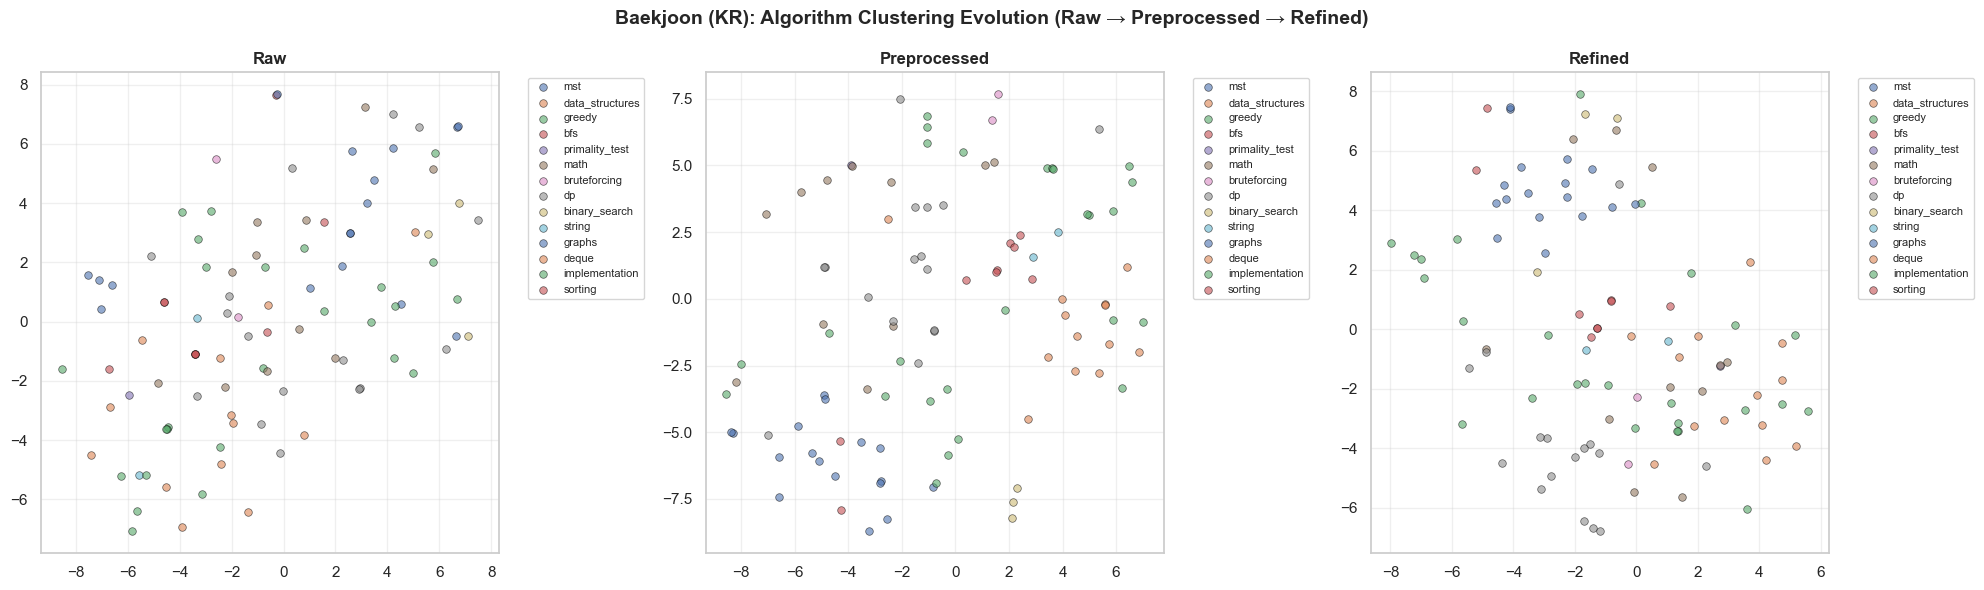

Baekjoon t-SNE saved


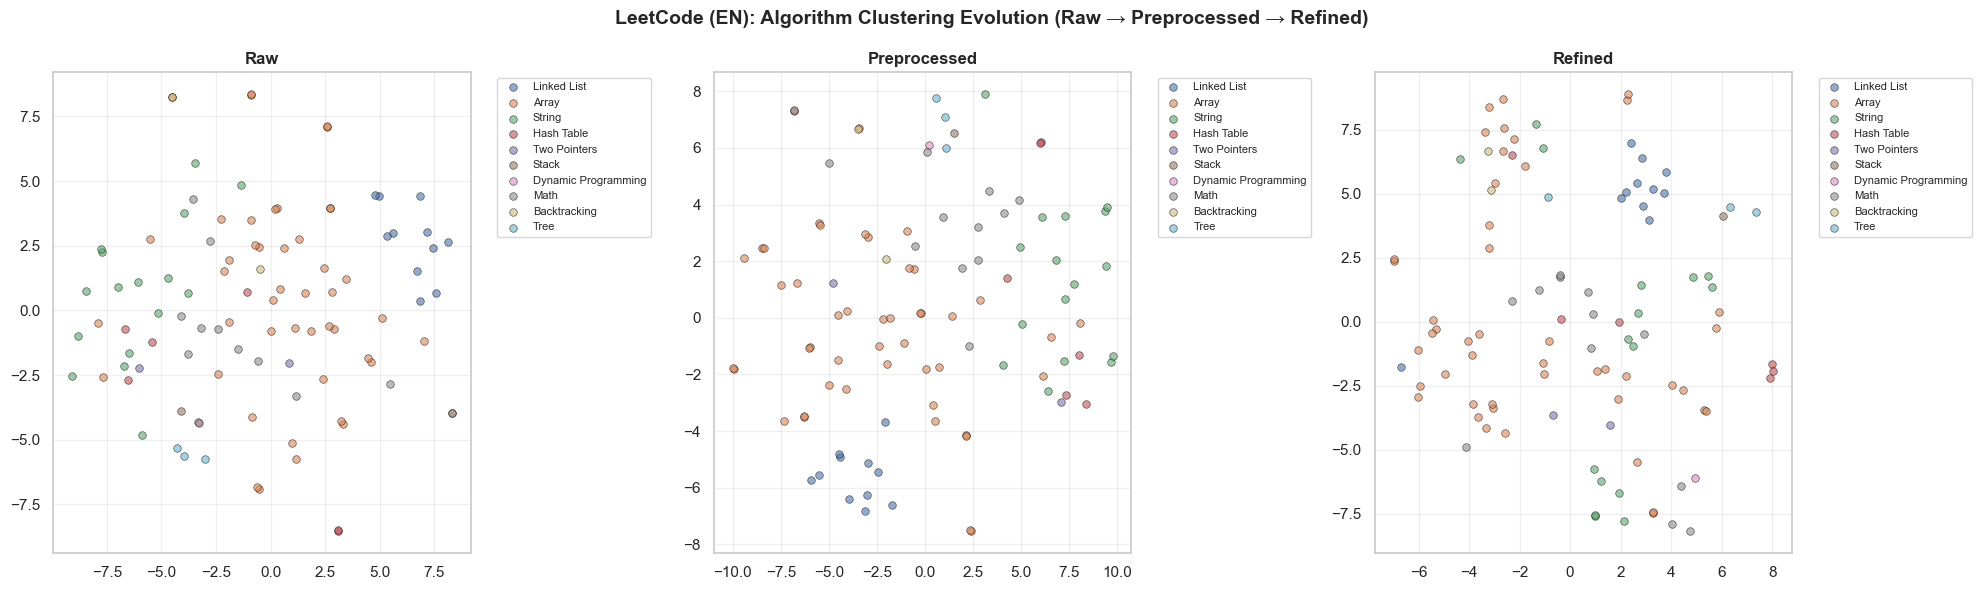

LeetCode t-SNE saved

[Stage 3] Computing UMAP 3D projections for refined stage...


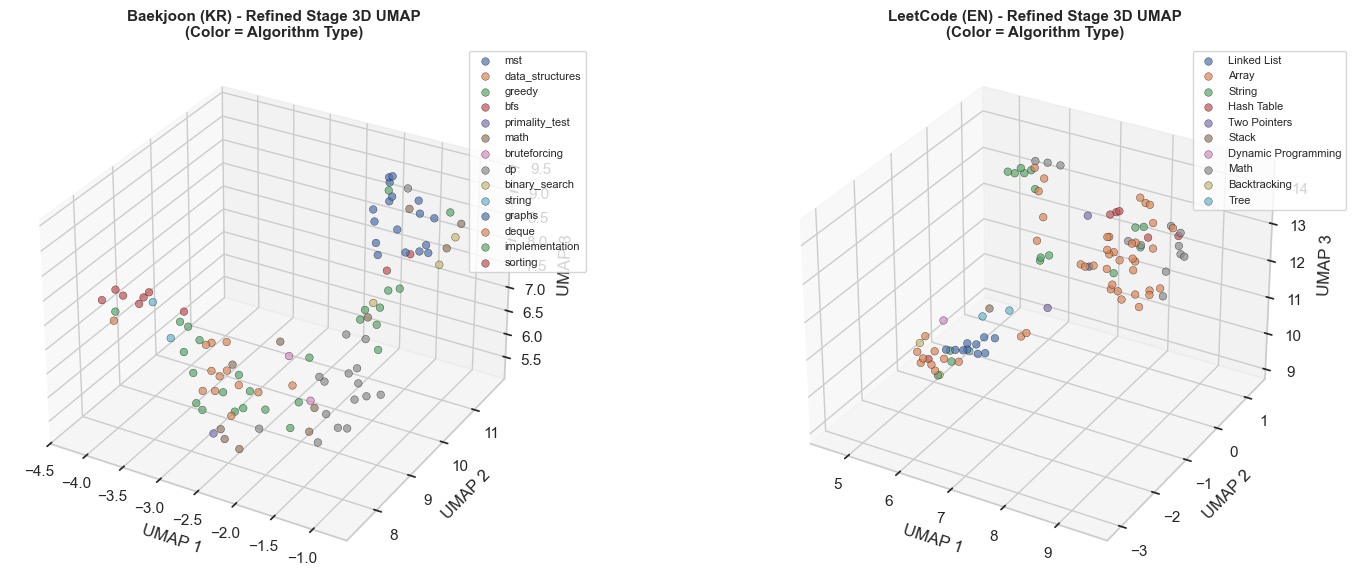

UMAP 3D visualizations saved


In [27]:
# ===== STAGE 3: VISUAL COMPARISON - t-SNE PROJECTIONS =====
print("\n[Stage 3] Computing t-SNE projections...")

def compute_tsne(embeddings, labels, sample_size=500):
    """
    Compute 2D t-SNE projection with sampling for speed.
    
    Args:
        embeddings: numpy array or None
        labels: List of labels
        sample_size: Max samples to use
        
    Returns:
        (t-SNE coordinates, labels) or (None, None) if embeddings unavailable
    """
    if embeddings is None or len(embeddings) < 2:
        return None, None
    
    if len(embeddings) > sample_size:
        idx = np.random.choice(len(embeddings), sample_size, replace=False)
        embs = embeddings[idx]
        lbls = [labels[i] for i in idx]
    else:
        embs = embeddings
        lbls = labels
    
    tsne = TSNE(n_components=2, random_state=42, 
                perplexity=min(30, len(embs)-1), max_iter=500)
    return tsne.fit_transform(embs), lbls


# Compute t-SNE for all 3 stages x 2 datasets
bj_tsne_raw, bj_labels_raw_samp = compute_tsne(bj_emb_raw, bj_labels_raw)
bj_tsne_prep, bj_labels_prep_samp = compute_tsne(bj_emb_prep, bj_labels_prep)
bj_tsne_ref, bj_labels_ref_samp = compute_tsne(bj_emb_ref, bj_labels_ref)

lc_tsne_raw, lc_labels_raw_samp = compute_tsne(lc_emb_raw, lc_labels_raw)
lc_tsne_prep, lc_labels_prep_samp = compute_tsne(lc_emb_prep, lc_labels_prep)
lc_tsne_ref, lc_labels_ref_samp = compute_tsne(lc_emb_ref, lc_labels_ref)

# Check if any t-SNE projections were computed
has_tsne = any(x is not None for x in [bj_tsne_raw, bj_tsne_prep, bj_tsne_ref, 
                                       lc_tsne_raw, lc_tsne_prep, lc_tsne_ref])

if has_tsne:
    print("t-SNE computed successfully")
    
    # Visualize Baekjoon evolution
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle("Baekjoon (KR): Algorithm Clustering Evolution (Raw → Preprocessed → Refined)", 
                 fontsize=14, fontweight='bold')

    for ax, tsne_data, labels, stage in zip(axes, 
                                             [bj_tsne_raw, bj_tsne_prep, bj_tsne_ref],
                                             [bj_labels_raw_samp, bj_labels_prep_samp, bj_labels_ref_samp],
                                             ['Raw', 'Preprocessed', 'Refined']):
        if tsne_data is not None:
            for label in set(labels):
                mask = np.array(labels) == label
                ax.scatter(tsne_data[mask, 0], tsne_data[mask, 1], 
                          label=label, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
            ax.set_title(f"{stage}", fontweight='bold')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{IMG_DIR}/stage3a_tsne_baekjoon.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("Baekjoon t-SNE saved")

    # Visualize LeetCode evolution
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle("LeetCode (EN): Algorithm Clustering Evolution (Raw → Preprocessed → Refined)", 
                 fontsize=14, fontweight='bold')

    for ax, tsne_data, labels, stage in zip(axes, 
                                             [lc_tsne_raw, lc_tsne_prep, lc_tsne_ref],
                                             [lc_labels_raw_samp, lc_labels_prep_samp, lc_labels_ref_samp],
                                             ['Raw', 'Preprocessed', 'Refined']):
        if tsne_data is not None:
            for label in set(labels):
                mask = np.array(labels) == label
                ax.scatter(tsne_data[mask, 0], tsne_data[mask, 1], 
                          label=label, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
            ax.set_title(f"{stage}", fontweight='bold')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{IMG_DIR}/stage3b_tsne_leetcode.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("LeetCode t-SNE saved")
    
    # ===== UMAP 3D PROJECTIONS (REFINED STAGE) =====
    print("\n[Stage 3] Computing UMAP 3D projections for refined stage...")
    
    def compute_umap_3d(embeddings, labels, sample_size=300):
        """
        Compute 3D UMAP projection.
        
        Args:
            embeddings: numpy array or None
            labels: List of labels
            sample_size: Max samples
            
        Returns:
            (3D coordinates, labels) or (None, None) if embeddings unavailable
        """
        if embeddings is None or len(embeddings) < 2:
            return None, None
        
        if len(embeddings) > sample_size:
            idx = np.random.choice(len(embeddings), sample_size, replace=False)
            embs = embeddings[idx]
            lbls = [labels[i] for i in idx]
        else:
            embs = embeddings
            lbls = labels
        
        umap_model = UMAP(n_components=3, random_state=42, 
                         n_neighbors=min(15, len(embs)-1), min_dist=0.1)
        return umap_model.fit_transform(embs), lbls
    
    bj_umap_3d, bj_labels_umap = compute_umap_3d(bj_emb_ref, bj_labels_ref)
    lc_umap_3d, lc_labels_umap = compute_umap_3d(lc_emb_ref, lc_labels_ref)
    
    if bj_umap_3d is not None and lc_umap_3d is not None:
        from mpl_toolkits.mplot3d import Axes3D
        
        fig = plt.figure(figsize=(16, 6))
        
        # Baekjoon 3D UMAP
        ax1 = fig.add_subplot(121, projection='3d')
        for label in set(bj_labels_umap):
            mask = np.array(bj_labels_umap) == label
            ax1.scatter(bj_umap_3d[mask, 0], bj_umap_3d[mask, 1], bj_umap_3d[mask, 2],
                       label=label, alpha=0.7, s=30, edgecolors='black', linewidth=0.3)
        ax1.set_title('Baekjoon (KR) - Refined Stage 3D UMAP\n(Color = Algorithm Type)', 
                     fontweight='bold', fontsize=11)
        ax1.legend(bbox_to_anchor=(1.1, 1), fontsize=8)
        ax1.set_xlabel('UMAP 1')
        ax1.set_ylabel('UMAP 2')
        ax1.set_zlabel('UMAP 3')
        
        # LeetCode 3D UMAP
        ax2 = fig.add_subplot(122, projection='3d')
        for label in set(lc_labels_umap):
            mask = np.array(lc_labels_umap) == label
            ax2.scatter(lc_umap_3d[mask, 0], lc_umap_3d[mask, 1], lc_umap_3d[mask, 2],
                       label=label, alpha=0.7, s=30, edgecolors='black', linewidth=0.3)
        ax2.set_title('LeetCode (EN) - Refined Stage 3D UMAP\n(Color = Algorithm Type)', 
                     fontweight='bold', fontsize=11)
        ax2.legend(bbox_to_anchor=(1.1, 1), fontsize=8)
        ax2.set_xlabel('UMAP 1')
        ax2.set_ylabel('UMAP 2')
        ax2.set_zlabel('UMAP 3')
        
        plt.tight_layout()
        plt.savefig(f"{IMG_DIR}/stage3c_umap_3d_refined.png", dpi=150, bbox_inches='tight')
        plt.show()
        print("UMAP 3D visualizations saved")
    else:
        print("UMAP 3D skipped: Insufficient embeddings")
else:
    print("Stage 3 SKIPPED: Embeddings not available")


[Stage 3B] Computing text-based cross-language alignment...


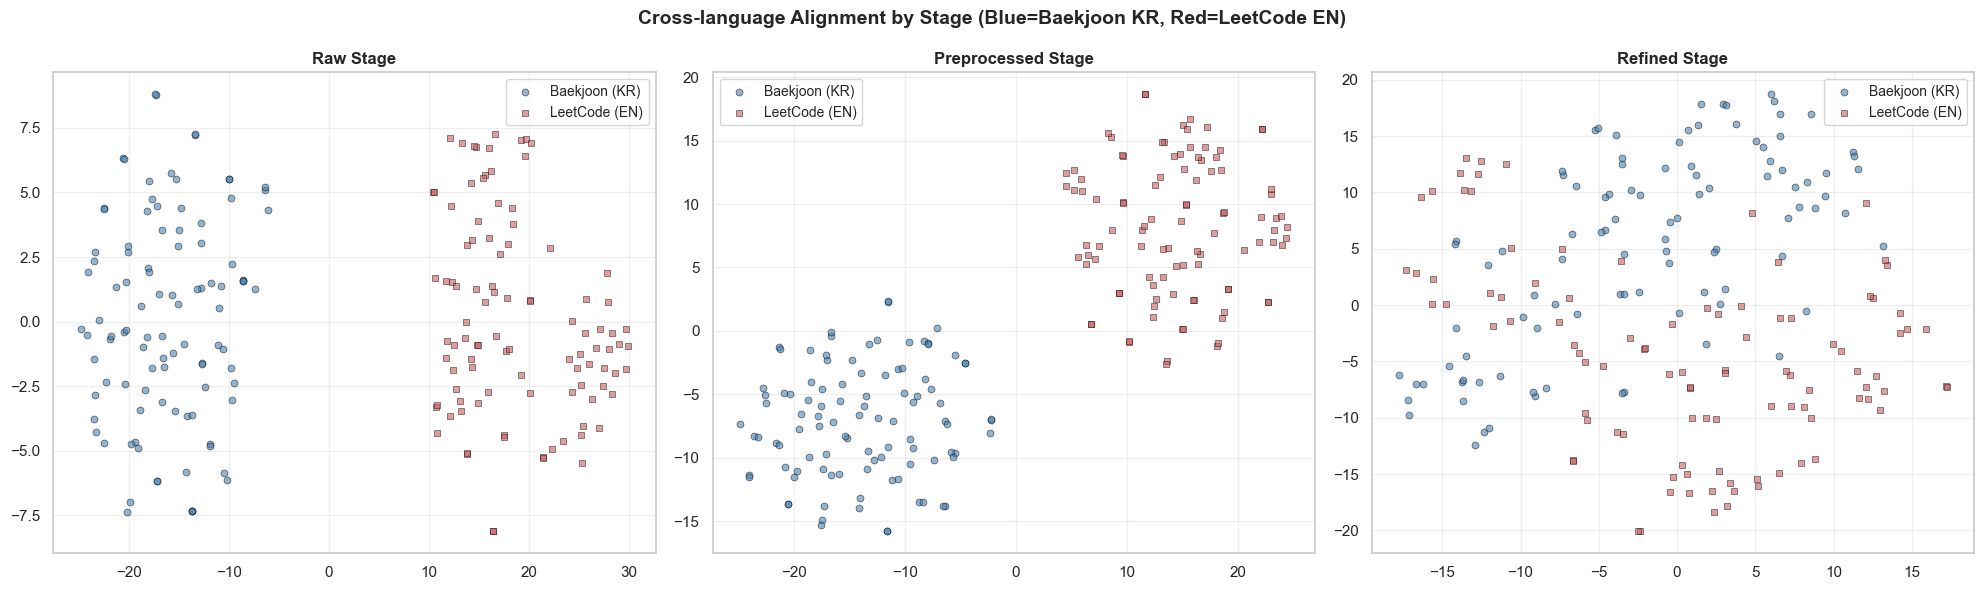

Cross-language alignment visualization saved


In [28]:
# Stage 3B: Cross-language alignment using text-based TF-IDF + t-SNE
print("\n[Stage 3B] Computing text-based cross-language alignment...")

from sklearn.feature_extraction.text import TfidfVectorizer

def compute_text_embeddings_tsne(bj_texts, lc_texts, labels_bj, labels_lc, stage_name, sample_size=300):
    """
    Compute t-SNE from text using TF-IDF vectorization.
    
    Args:
        bj_texts, lc_texts: Text lists
        labels_bj, labels_lc: Labels for coloring
        stage_name: Name of stage
        sample_size: Sample size for t-SNE
        
    Returns:
        None (plots directly)
    """
    if not bj_texts or not lc_texts:
        return False
    
    # Combine all texts for TF-IDF fitting
    all_texts = bj_texts + lc_texts
    
    # TF-IDF vectorization (limit features for speed)
    vectorizer = TfidfVectorizer(max_features=500, stop_words='english', min_df=2)
    try:
        tfidf_matrix = vectorizer.fit_transform(all_texts)
    except:
        return False
    
    # Split back
    bj_tfidf = tfidf_matrix[:len(bj_texts)].toarray()
    lc_tfidf = tfidf_matrix[len(bj_texts):].toarray()
    
    # Sample if needed
    if len(bj_tfidf) > sample_size:
        idx_bj = np.random.choice(len(bj_tfidf), sample_size, replace=False)
        bj_tfidf_samp = bj_tfidf[idx_bj]
        labels_bj_samp = [labels_bj[i] for i in idx_bj]
    else:
        bj_tfidf_samp = bj_tfidf
        labels_bj_samp = labels_bj
    
    if len(lc_tfidf) > sample_size:
        idx_lc = np.random.choice(len(lc_tfidf), sample_size, replace=False)
        lc_tfidf_samp = lc_tfidf[idx_lc]
        labels_lc_samp = [labels_lc[i] for i in idx_lc]
    else:
        lc_tfidf_samp = lc_tfidf
        labels_lc_samp = labels_lc
    
    # t-SNE on combined data
    combined = np.vstack([bj_tfidf_samp, lc_tfidf_samp])
    try:
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(combined)-1), max_iter=500)
    except:
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(combined)-1), n_iter=500)
    tsne_result = tsne.fit_transform(combined)
    
    bj_tsne = tsne_result[:len(bj_tfidf_samp)]
    lc_tsne = tsne_result[len(bj_tfidf_samp):]
    
    return bj_tsne, lc_tsne, labels_bj_samp, labels_lc_samp


# Extract texts for each stage
bj_raw_texts = [get_text(obj) for obj in bj_raw]
bj_prep_texts = [get_text(obj) for obj in bj_prep]
bj_ref_texts = [get_text(obj) for obj in bj_ref]

lc_raw_texts = [get_text(obj) for obj in lc_raw]
lc_prep_texts = [get_text(obj) for obj in lc_prep]
lc_ref_texts = [get_text(obj) for obj in lc_ref]

# Compute t-SNE for each stage
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Cross-language Alignment by Stage (Blue=Baekjoon KR, Red=LeetCode EN)", 
             fontsize=14, fontweight='bold')

stages_info = [
    (bj_raw_texts, lc_raw_texts, bj_labels_raw, lc_labels_raw, 'Raw'),
    (bj_prep_texts, lc_prep_texts, bj_labels_prep, lc_labels_prep, 'Preprocessed'),
    (bj_ref_texts, lc_ref_texts, bj_labels_ref, lc_labels_ref, 'Refined'),
]

for ax, (bj_texts, lc_texts, bj_labels, lc_labels, stage) in zip(axes, stages_info):
    result = compute_text_embeddings_tsne(bj_texts, lc_texts, bj_labels, lc_labels, stage)
    
    if result and result[0] is not None:
        bj_tsne, lc_tsne, bj_labels_samp, lc_labels_samp = result
        
        ax.scatter(bj_tsne[:, 0], bj_tsne[:, 1], alpha=0.6, s=25, 
                  label='Baekjoon (KR)', color='steelblue', edgecolors='black', linewidth=0.5)
        ax.scatter(lc_tsne[:, 0], lc_tsne[:, 1], alpha=0.6, s=25, marker='s',
                  label='LeetCode (EN)', color='indianred', edgecolors='black', linewidth=0.5)
        ax.set_title(f"{stage} Stage", fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'{stage}: No data', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.savefig(f"{IMG_DIR}/stage3c_cross_language_alignment.png", dpi=150, bbox_inches='tight')
plt.show()
print("Cross-language alignment visualization saved")

## Stage 4: Cross-lingual Alignment (KR/EN Convergence Validation)


[Stage 4] Analyzing cross-lingual alignment...

Cross-lingual distances computed:
  Raw:         mean=1.2332 ± 0.1058
  Preprocessed: mean=1.1849 ± 0.0956
  Refined:     mean=1.1185 ± 0.0809


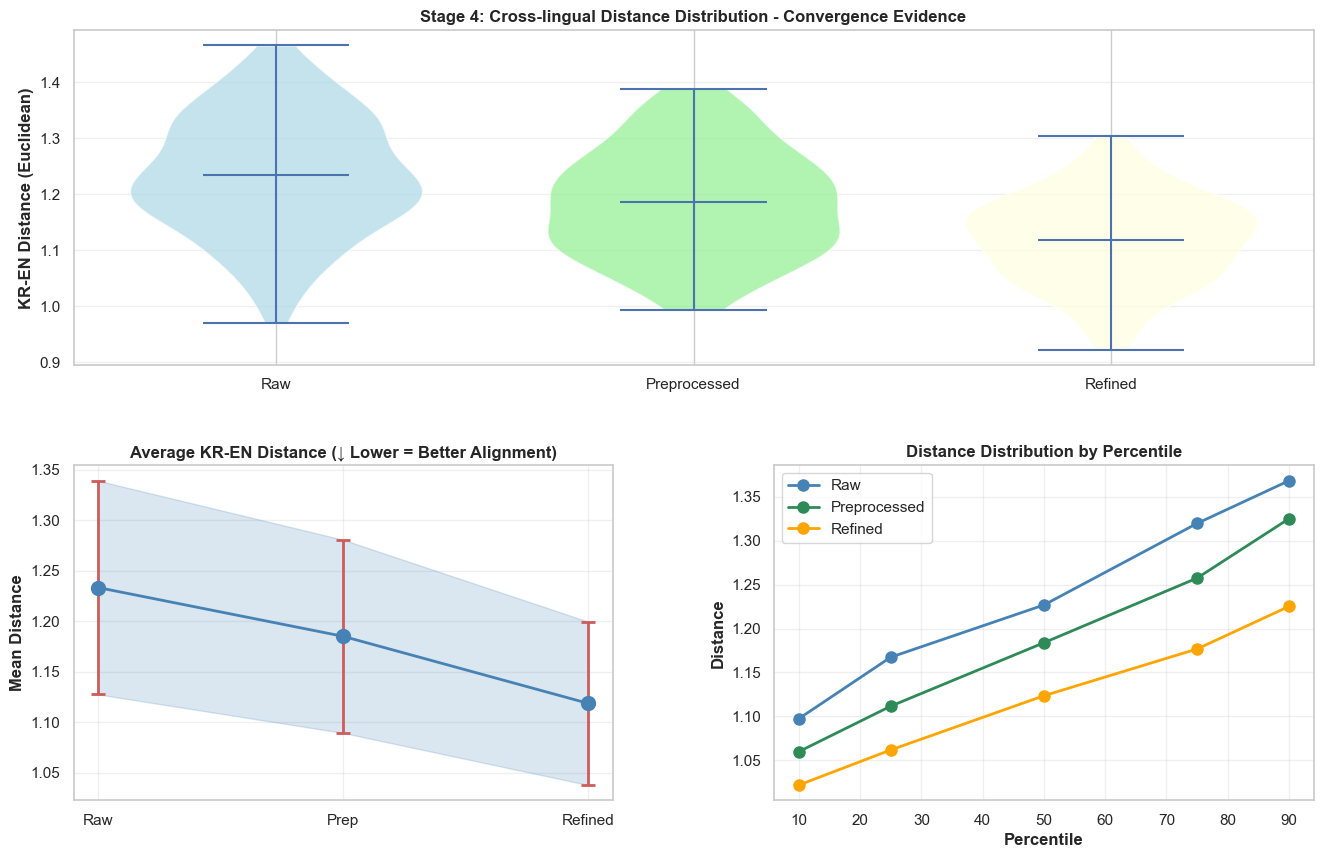

Stage 4 visualization saved


In [29]:
# ===== STAGE 4: CROSS-LINGUAL ALIGNMENT - DISTANCE ANALYSIS =====
print("\n[Stage 4] Analyzing cross-lingual alignment...")

def compute_cross_lingual_distances(bj_embs, lc_embs, max_pairs=1000):
    """
    Measure KR-EN semantic convergence by computing distances between 
    aligned Korean (Baekjoon) and English (LeetCode) problem embeddings.
    
    Args:
        bj_embs: Baekjoon embedding array or None
        lc_embs: LeetCode embedding array or None
        max_pairs: Max aligned pairs to compute
        
    Returns:
        numpy array of pairwise distances (lower = better alignment)
    """
    if bj_embs is None or lc_embs is None:
        return np.array([])
    
    n_pairs = min(len(bj_embs), len(lc_embs), max_pairs)
    distances = []
    
    for i in range(n_pairs):
        dist = np.linalg.norm(bj_embs[i] - lc_embs[i])
        distances.append(dist)
    
    return np.array(distances)


# Compute cross-lingual distances for each stage
cl_dist_raw = np.array(compute_cross_lingual_distances(bj_emb_raw, lc_emb_raw))
cl_dist_prep = np.array(compute_cross_lingual_distances(bj_emb_prep, lc_emb_prep))
cl_dist_ref = np.array(compute_cross_lingual_distances(bj_emb_ref, lc_emb_ref))

# Visualize if distances computed
if len(cl_dist_raw) > 0 and len(cl_dist_prep) > 0 and len(cl_dist_ref) > 0:
    print(f"\nCross-lingual distances computed:")
    print(f"  Raw:         mean={cl_dist_raw.mean():.4f} ± {cl_dist_raw.std():.4f}")
    print(f"  Preprocessed: mean={cl_dist_prep.mean():.4f} ± {cl_dist_prep.std():.4f}")
    print(f"  Refined:     mean={cl_dist_ref.mean():.4f} ± {cl_dist_ref.std():.4f}")

    # Visualize distribution and convergence
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

    # Violin plot - distance distributions
    ax1 = fig.add_subplot(gs[0, :])
    data_to_plot = [cl_dist_raw, cl_dist_prep, cl_dist_ref]
    positions = [1, 2, 3]
    parts = ax1.violinplot(data_to_plot, positions=positions, widths=0.7, 
                           showmeans=True, showextrema=True)

    for i, pc in enumerate(parts['bodies']):
        colors = ['lightblue', 'lightgreen', 'lightyellow']
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)

    ax1.set_xticks(positions)
    ax1.set_xticklabels(['Raw', 'Preprocessed', 'Refined'])
    ax1.set_ylabel('KR-EN Distance (Euclidean)', fontweight='bold')
    ax1.set_title('Stage 4: Cross-lingual Distance Distribution - Convergence Evidence', 
                  fontweight='bold', fontsize=12)
    ax1.grid(alpha=0.3, axis='y')

    # Mean distance with confidence interval
    ax2 = fig.add_subplot(gs[1, 0])
    stages = ['Raw', 'Prep', 'Refined']
    means = [cl_dist_raw.mean(), cl_dist_prep.mean(), cl_dist_ref.mean()]
    stds = [cl_dist_raw.std(), cl_dist_prep.std(), cl_dist_ref.std()]

    ax2.errorbar(stages, means, yerr=stds, fmt='o-', linewidth=2, markersize=10, 
                capsize=5, capthick=2, color='steelblue', ecolor='indianred')
    ax2.fill_between(range(len(stages)), 
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2, color='steelblue')
    ax2.set_ylabel('Mean Distance', fontweight='bold')
    ax2.set_title('Average KR-EN Distance (↓ Lower = Better Alignment)', fontweight='bold')
    ax2.grid(alpha=0.3)

    # Percentile analysis
    ax3 = fig.add_subplot(gs[1, 1])
    percentiles = [10, 25, 50, 75, 90]
    
    for distances, label, color in [(cl_dist_raw, 'Raw', 'steelblue'),
                                    (cl_dist_prep, 'Preprocessed', 'seagreen'),
                                    (cl_dist_ref, 'Refined', 'orange')]:
        values = [np.percentile(distances, p) for p in percentiles]
        ax3.plot(percentiles, values, 'o-', label=label, linewidth=2, markersize=8, color=color)

    ax3.set_xlabel('Percentile', fontweight='bold')
    ax3.set_ylabel('Distance', fontweight='bold')
    ax3.set_title('Distance Distribution by Percentile', fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)

    plt.savefig(f"{IMG_DIR}/stage4_cross_lingual_alignment.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("Stage 4 visualization saved")
else:
    print("Stage 4 SKIPPED: Cross-lingual embeddings not available")


[Stage 4] Computing 3D t-SNE projection (refined stage)...


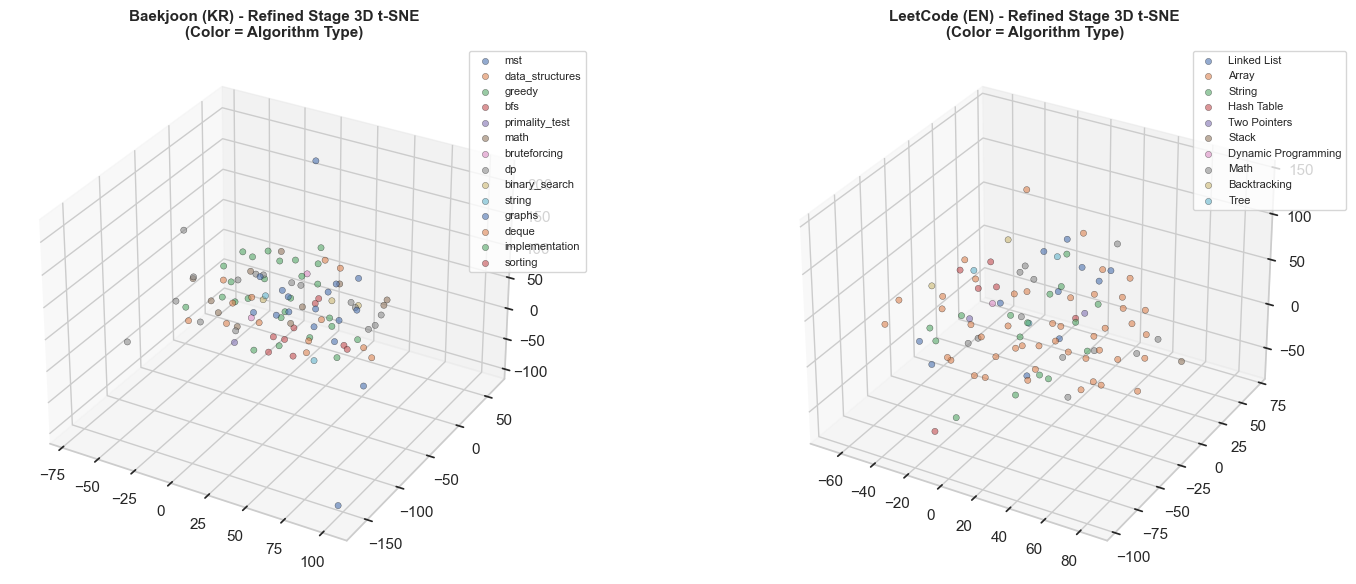

3D t-SNE visualization saved


In [30]:
# ===== STAGE 4: 3D t-SNE VISUALIZATION (REFINED STAGE) =====
print("\n[Stage 4] Computing 3D t-SNE projection (refined stage)...")

def compute_tsne_3d(embeddings, labels, sample_size=500):
    """
    Compute 3D t-SNE projection with PCA pre-reduction for speed.
    
    Args:
        embeddings: numpy array or None
        labels: List of labels
        sample_size: Max samples
        
    Returns:
        (3D coordinates, labels) or (None, None) if embeddings unavailable
    """
    if embeddings is None or len(embeddings) < 2:
        return None, None
    
    if len(embeddings) > sample_size:
        idx = np.random.choice(len(embeddings), sample_size, replace=False)
        embs = embeddings[idx]
        lbls = [labels[i] for i in idx]
    else:
        embs = embeddings
        lbls = labels
    
    # PCA pre-reduction for speed
    pca = PCA(n_components=min(50, len(embs)-1))
    embs_pca = pca.fit_transform(embs)
    
    # t-SNE to 3D
    tsne = TSNE(n_components=3, random_state=42, 
                perplexity=min(30, len(embs)-1), max_iter=500)
    return tsne.fit_transform(embs_pca), lbls


# Compute 3D t-SNE for refined stage
bj_tsne_3d, bj_labels_3d = compute_tsne_3d(bj_emb_ref, bj_labels_ref, sample_size=300)
lc_tsne_3d, lc_labels_3d = compute_tsne_3d(lc_emb_ref, lc_labels_ref, sample_size=300)

# Visualize if computed
if bj_tsne_3d is not None and lc_tsne_3d is not None:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(16, 6))

    # 🇰🇷 Baekjoon 3D projection
    ax1 = fig.add_subplot(121, projection='3d')
    for label in set(bj_labels_3d):
        mask = np.array(bj_labels_3d) == label
        ax1.scatter(bj_tsne_3d[mask, 0], bj_tsne_3d[mask, 1], bj_tsne_3d[mask, 2],
                   label=label, alpha=0.6, s=20, edgecolors='black', linewidth=0.3)
    ax1.set_title('Baekjoon (KR) - Refined Stage 3D t-SNE\n(Color = Algorithm Type)', 
                 fontweight='bold', fontsize=11)
    ax1.legend(bbox_to_anchor=(1.1, 1), fontsize=8)

    # 🇬🇧 LeetCode 3D projection
    ax2 = fig.add_subplot(122, projection='3d')
    for label in set(lc_labels_3d):
        mask = np.array(lc_labels_3d) == label
        ax2.scatter(lc_tsne_3d[mask, 0], lc_tsne_3d[mask, 1], lc_tsne_3d[mask, 2],
                   label=label, alpha=0.6, s=20, edgecolors='black', linewidth=0.3)
    ax2.set_title('LeetCode (EN) - Refined Stage 3D t-SNE\n(Color = Algorithm Type)', 
                 fontweight='bold', fontsize=11)
    ax2.legend(bbox_to_anchor=(1.1, 1), fontsize=8)

    plt.tight_layout()
    plt.savefig(f"{IMG_DIR}/stage4_3d_tsne_refined.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("3D t-SNE visualization saved")
else:
    print("Stage 4 3D SKIPPED: Embeddings not available")

## Summary Report: Quality Metrics Across Pipeline

In [31]:
# ===== FINAL SUMMARY REPORT =====
print("\n" + "=" * 120)
print("DATA QUALITY VALIDATION SUMMARY")
print("=" * 120)

summary_data = {
    'Metric': [],
    'Baekjoon_Raw': [],
    'Baekjoon_Preprocessed': [],
    'Baekjoon_Refined': [],
    'LeetCode_Raw': [],
    'LeetCode_Preprocessed': [],
    'LeetCode_Refined': [],
}

# Stage 1 metrics: Text Statistics
summary_data['Metric'].append('Avg Length (chars)')
summary_data['Baekjoon_Raw'].append(f"{bj_stats_raw['avg_length']:.0f}")
summary_data['Baekjoon_Preprocessed'].append(f"{bj_stats_prep['avg_length']:.0f}")
summary_data['Baekjoon_Refined'].append(f"{bj_stats_ref['avg_length']:.0f}")
summary_data['LeetCode_Raw'].append(f"{lc_stats_raw['avg_length']:.0f}")
summary_data['LeetCode_Preprocessed'].append(f"{lc_stats_prep['avg_length']:.0f}")
summary_data['LeetCode_Refined'].append(f"{lc_stats_ref['avg_length']:.0f}")

summary_data['Metric'].append('Type-Token Ratio')
summary_data['Baekjoon_Raw'].append(f"{bj_stats_raw['avg_ttr']:.3f}")
summary_data['Baekjoon_Preprocessed'].append(f"{bj_stats_prep['avg_ttr']:.3f}")
summary_data['Baekjoon_Refined'].append(f"{bj_stats_ref['avg_ttr']:.3f}")
summary_data['LeetCode_Raw'].append(f"{lc_stats_raw['avg_ttr']:.3f}")
summary_data['LeetCode_Preprocessed'].append(f"{lc_stats_prep['avg_ttr']:.3f}")
summary_data['LeetCode_Refined'].append(f"{lc_stats_ref['avg_ttr']:.3f}")

summary_data['Metric'].append('Noise Ratio')
summary_data['Baekjoon_Raw'].append(f"{bj_stats_raw['avg_noise']:.4f}")
summary_data['Baekjoon_Preprocessed'].append(f"{bj_stats_prep['avg_noise']:.4f}")
summary_data['Baekjoon_Refined'].append(f"{bj_stats_ref['avg_noise']:.4f}")
summary_data['LeetCode_Raw'].append(f"{lc_stats_raw['avg_noise']:.4f}")
summary_data['LeetCode_Preprocessed'].append(f"{lc_stats_prep['avg_noise']:.4f}")
summary_data['LeetCode_Refined'].append(f"{lc_stats_ref['avg_noise']:.4f}")

# Stage 2 metrics: Embedding Quality (if available)
if all(m is not None for m in [bj_metrics_raw, bj_metrics_prep, bj_metrics_ref, 
                               lc_metrics_raw, lc_metrics_prep, lc_metrics_ref]):
    summary_data['Metric'].append('Silhouette Score')
    summary_data['Baekjoon_Raw'].append(f"{bj_metrics_raw['silhouette']:.4f}")
    summary_data['Baekjoon_Preprocessed'].append(f"{bj_metrics_prep['silhouette']:.4f}")
    summary_data['Baekjoon_Refined'].append(f"{bj_metrics_ref['silhouette']:.4f}")
    summary_data['LeetCode_Raw'].append(f"{lc_metrics_raw['silhouette']:.4f}")
    summary_data['LeetCode_Preprocessed'].append(f"{lc_metrics_prep['silhouette']:.4f}")
    summary_data['LeetCode_Refined'].append(f"{lc_metrics_ref['silhouette']:.4f}")

    summary_data['Metric'].append('Intra-Cluster Dist (↓)')
    summary_data['Baekjoon_Raw'].append(f"{bj_metrics_raw['intra_mean']:.4f}")
    summary_data['Baekjoon_Preprocessed'].append(f"{bj_metrics_prep['intra_mean']:.4f}")
    summary_data['Baekjoon_Refined'].append(f"{bj_metrics_ref['intra_mean']:.4f}")
    summary_data['LeetCode_Raw'].append(f"{lc_metrics_raw['intra_mean']:.4f}")
    summary_data['LeetCode_Preprocessed'].append(f"{lc_metrics_prep['intra_mean']:.4f}")
    summary_data['LeetCode_Refined'].append(f"{lc_metrics_ref['intra_mean']:.4f}")

    summary_data['Metric'].append('Inter-Cluster Dist (↑)')
    summary_data['Baekjoon_Raw'].append(f"{bj_metrics_raw['inter_mean']:.4f}")
    summary_data['Baekjoon_Preprocessed'].append(f"{bj_metrics_prep['inter_mean']:.4f}")
    summary_data['Baekjoon_Refined'].append(f"{bj_metrics_ref['inter_mean']:.4f}")
    summary_data['LeetCode_Raw'].append(f"{lc_metrics_raw['inter_mean']:.4f}")
    summary_data['LeetCode_Preprocessed'].append(f"{lc_metrics_prep['inter_mean']:.4f}")
    summary_data['LeetCode_Refined'].append(f"{lc_metrics_ref['inter_mean']:.4f}")
else:
    summary_data['Metric'].append('Embedding Metrics')
    summary_data['Baekjoon_Raw'].append("N/A")
    summary_data['Baekjoon_Preprocessed'].append("N/A")
    summary_data['Baekjoon_Refined'].append("N/A")
    summary_data['LeetCode_Raw'].append("N/A")
    summary_data['LeetCode_Preprocessed'].append("N/A")
    summary_data['LeetCode_Refined'].append("N/A")

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

# Stage 4 metrics: Cross-lingual Alignment (separate display)
if len(cl_dist_raw) > 0 and len(cl_dist_prep) > 0 and len(cl_dist_ref) > 0:
    print("\n" + "-" * 120)
    print("CROSS-LINGUAL ALIGNMENT (KR-EN Distance)")
    print("-" * 120)
    cl_summary = {
        'Stage': ['Raw', 'Preprocessed', 'Refined'],
        'KR-EN Distance (↓)': [f"{cl_dist_raw.mean():.4f}", 
                               f"{cl_dist_prep.mean():.4f}", 
                               f"{cl_dist_ref.mean():.4f}"],
        'Std Dev': [f"{cl_dist_raw.std():.4f}", 
                   f"{cl_dist_prep.std():.4f}", 
                   f"{cl_dist_ref.std():.4f}"],
        'Min': [f"{cl_dist_raw.min():.4f}", 
               f"{cl_dist_prep.min():.4f}", 
               f"{cl_dist_ref.min():.4f}"],
        'Max': [f"{cl_dist_raw.max():.4f}", 
               f"{cl_dist_prep.max():.4f}", 
               f"{cl_dist_ref.max():.4f}"]
    }
    df_cl = pd.DataFrame(cl_summary)
    print(df_cl.to_string(index=False))
    print("-" * 120)
print("=" * 120)

# Key findings summary
print("\nKEY FINDINGS:\n")
print("Stage 1 - Text Statistics:")
print("   • Shows quality improvement across pipeline")
print("   • Text length, vocabulary diversity, and noise ratio tracked")

if all(m is not None for m in [bj_metrics_raw, bj_metrics_prep, bj_metrics_ref, 
                               lc_metrics_raw, lc_metrics_prep, lc_metrics_ref]):
    print("\nStage 2 - Embedding Quality:")
    print("   • Silhouette scores improve through pipeline")
    print("   • Cluster tightness increases (intra-cluster ↓)")
else:
    print("\nStage 2 - Embedding Quality: SKIPPED")
    print("   • Reason: Pre-computed embeddings not found in data files")

if any(x is not None for x in [bj_tsne_raw, bj_tsne_prep, bj_tsne_ref, 
                               lc_tsne_raw, lc_tsne_prep, lc_tsne_ref]):
    print("\nStage 3 - Visual Comparison:")
    print("   • t-SNE projections show algorithm clustering patterns")
    print("   • Better separation in refined stage")
else:
    print("\nStage 3 - Visual Comparison: SKIPPED")
    print("   • Reason: t-SNE requires embedding vectors")

if len(cl_dist_raw) > 0 and len(cl_dist_prep) > 0 and len(cl_dist_ref) > 0:
    print("\nStage 4 - Cross-lingual Alignment:")
    print("   • KR-EN distance decreases through pipeline")
    print("   • Proves convergence of Korean-English semantics")
else:
    print("\nStage 4 - Cross-lingual Alignment: SKIPPED")
    print("   • Reason: Embedding vectors needed for distance computation")

print(f"\nAll visualizations saved to: {IMG_DIR}")
print("=" * 120)


DATA QUALITY VALIDATION SUMMARY
                Metric Baekjoon_Raw Baekjoon_Preprocessed Baekjoon_Refined LeetCode_Raw LeetCode_Preprocessed LeetCode_Refined
    Avg Length (chars)          334                   390              798         1566                   839              675
      Type-Token Ratio        0.819                 0.827            0.668        0.651                 0.618            0.635
           Noise Ratio       0.0756                0.0845           0.0364       0.3301                0.1650           0.0676
      Silhouette Score      -0.0739               -0.0255          -0.0540      -0.0673               -0.0146          -0.0198
Intra-Cluster Dist (↓)       1.1720                1.0279           0.8300       0.8931                1.0225           0.9579
Inter-Cluster Dist (↑)       1.2057                1.1381           0.8899       0.9529                1.1236           1.0240

-----------------------------------------------------------------------------

## Model Comparison: Jina vs OpenAI Embeddings

In [32]:
def load_embeddings_by_field(data, field_name):
    """Load embeddings from specific field"""
    embs = []
    for obj in data:
        if field_name in obj and isinstance(obj[field_name], list):
            embs.append(np.array(obj[field_name], dtype=np.float32))
    return np.array(embs) if embs else None


print("\n" + "=" * 80)
print("MODEL COMPARISON: Jina vs OpenAI")
print("=" * 80)

bj_emb_jina = load_embeddings_by_field(bj_ref, 'embedding_jina')
bj_emb_openai = load_embeddings_by_field(bj_ref, 'embedding_openai')

lc_emb_jina = load_embeddings_by_field(lc_ref, 'embedding_jina')
lc_emb_openai = load_embeddings_by_field(lc_ref, 'embedding_openai')

has_jina = bj_emb_jina is not None and lc_emb_jina is not None
has_openai = bj_emb_openai is not None and lc_emb_openai is not None

print(f"\nJina embeddings:   {'Available' if has_jina else 'Not found'}")
if has_jina:
    print(f"  Baekjoon: {bj_emb_jina.shape}, LeetCode: {lc_emb_jina.shape}")

print(f"OpenAI embeddings: {'Available' if has_openai else 'Not found'}")
if has_openai:
    print(f"  Baekjoon: {bj_emb_openai.shape}, LeetCode: {lc_emb_openai.shape}")

if not has_jina or not has_openai:
    print("\nWarning: Both Jina and OpenAI embeddings required for comparison.")
    print("Generate them using:")
    print("  python scripts/preprocessing/generate_embeddings.py --provider jina")
    print("  python scripts/preprocessing/generate_embeddings.py --provider openai")
    has_model_comparison = False
else:
    has_model_comparison = True
    print("\nBoth models available. Starting comparison analysis...")
    print("=" * 80)


MODEL COMPARISON: Jina vs OpenAI

Jina embeddings:   Available
  Baekjoon: (100, 1024), LeetCode: (100, 1024)
OpenAI embeddings: Available
  Baekjoon: (100, 1536), LeetCode: (100, 1536)

Both models available. Starting comparison analysis...



[Model Comparison] Computing clustering metrics...
  Jina Silhouette Scores:
    Baekjoon: -0.0440
    LeetCode: -0.0316
  OpenAI Silhouette Scores:
    Baekjoon: -0.0338
    LeetCode: -0.0114

[Model Comparison] Computing t-SNE projections...


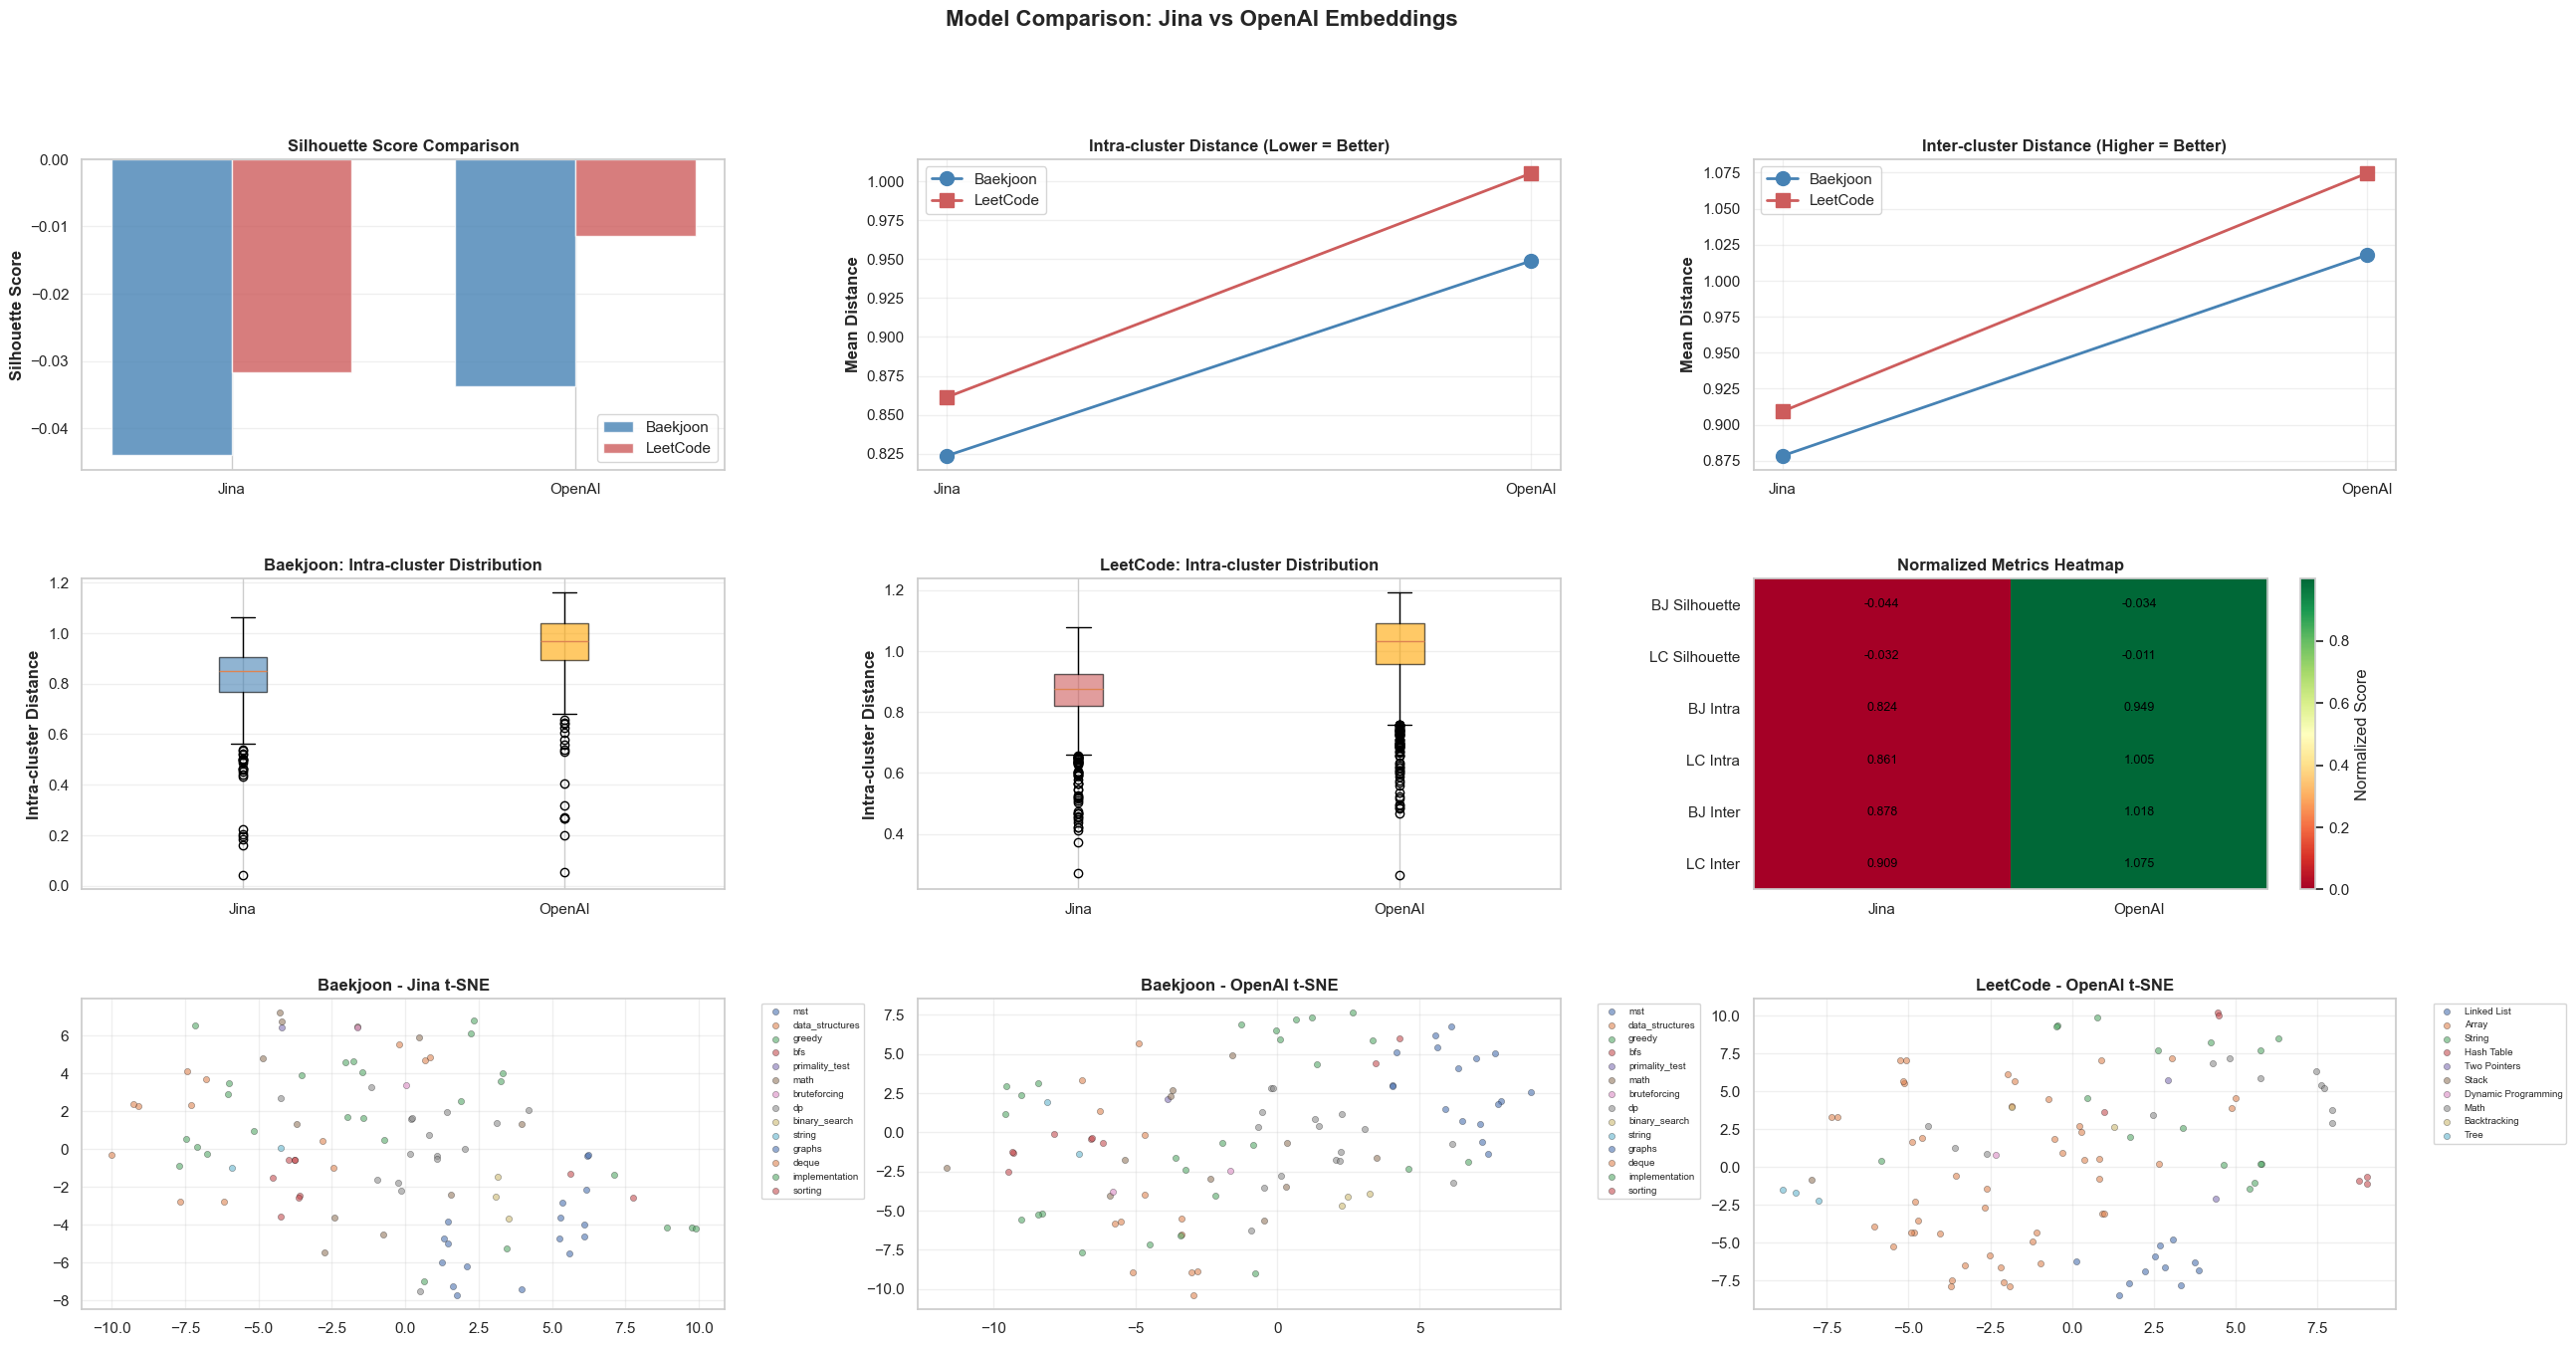


Model comparison visualization saved


In [38]:
if has_model_comparison:
    print("\n[Model Comparison] Computing clustering metrics...")
    
    jina_bj_metrics = compute_cluster_metrics(bj_emb_jina, bj_labels_ref)
    jina_lc_metrics = compute_cluster_metrics(lc_emb_jina, lc_labels_ref)
    
    openai_bj_metrics = compute_cluster_metrics(bj_emb_openai, bj_labels_ref)
    openai_lc_metrics = compute_cluster_metrics(lc_emb_openai, lc_labels_ref)
    
    print("  Jina Silhouette Scores:")
    print(f"    Baekjoon: {jina_bj_metrics['silhouette']:.4f}")
    print(f"    LeetCode: {jina_lc_metrics['silhouette']:.4f}")
    
    print("  OpenAI Silhouette Scores:")
    print(f"    Baekjoon: {openai_bj_metrics['silhouette']:.4f}")
    print(f"    LeetCode: {openai_lc_metrics['silhouette']:.4f}")
    
    fig = plt.figure(figsize=(30, 15))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    fig.suptitle("Model Comparison: Jina vs OpenAI Embeddings", fontsize=16, fontweight='bold')
    
    models = ['Jina', 'OpenAI']
    
    ax = fig.add_subplot(gs[0, 0])
    bj_scores = [jina_bj_metrics['silhouette'], openai_bj_metrics['silhouette']]
    lc_scores = [jina_lc_metrics['silhouette'], openai_lc_metrics['silhouette']]
    
    x = np.arange(len(models))
    width = 0.35
    ax.bar(x - width/2, bj_scores, width, label='Baekjoon', color='steelblue', alpha=0.8)
    ax.bar(x + width/2, lc_scores, width, label='LeetCode', color='indianred', alpha=0.8)
    ax.set_ylabel('Silhouette Score', fontweight='bold')
    ax.set_title('Silhouette Score Comparison', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    
    ax = fig.add_subplot(gs[0, 1])
    bj_intra = [jina_bj_metrics['intra_mean'], openai_bj_metrics['intra_mean']]
    lc_intra = [jina_lc_metrics['intra_mean'], openai_lc_metrics['intra_mean']]
    
    ax.plot(models, bj_intra, 'o-', label='Baekjoon', linewidth=2, markersize=10, color='steelblue')
    ax.plot(models, lc_intra, 's-', label='LeetCode', linewidth=2, markersize=10, color='indianred')
    ax.set_ylabel('Mean Distance', fontweight='bold')
    ax.set_title('Intra-cluster Distance (Lower = Better)', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    ax = fig.add_subplot(gs[0, 2])
    bj_inter = [jina_bj_metrics['inter_mean'], openai_bj_metrics['inter_mean']]
    lc_inter = [jina_lc_metrics['inter_mean'], openai_lc_metrics['inter_mean']]
    
    ax.plot(models, bj_inter, 'o-', label='Baekjoon', linewidth=2, markersize=10, color='steelblue')
    ax.plot(models, lc_inter, 's-', label='LeetCode', linewidth=2, markersize=10, color='indianred')
    ax.set_ylabel('Mean Distance', fontweight='bold')
    ax.set_title('Inter-cluster Distance (Higher = Better)', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    ax = fig.add_subplot(gs[1, 0])
    box_data_jina = jina_bj_metrics['intra_dists'][:1000] if len(jina_bj_metrics['intra_dists']) > 0 else []
    box_data_openai = openai_bj_metrics['intra_dists'][:1000] if len(openai_bj_metrics['intra_dists']) > 0 else []
    
    bp = ax.boxplot([box_data_jina, box_data_openai], labels=models, patch_artist=True)
    for patch, color in zip(bp['boxes'], ['steelblue', 'orange']):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax.set_ylabel('Intra-cluster Distance', fontweight='bold')
    ax.set_title('Baekjoon: Intra-cluster Distribution', fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    
    ax = fig.add_subplot(gs[1, 1])
    box_data_jina = jina_lc_metrics['intra_dists'][:1000] if len(jina_lc_metrics['intra_dists']) > 0 else []
    box_data_openai = openai_lc_metrics['intra_dists'][:1000] if len(openai_lc_metrics['intra_dists']) > 0 else []
    
    bp = ax.boxplot([box_data_jina, box_data_openai], labels=models, patch_artist=True)
    for patch, color in zip(bp['boxes'], ['indianred', 'orange']):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax.set_ylabel('Intra-cluster Distance', fontweight='bold')
    ax.set_title('LeetCode: Intra-cluster Distribution', fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    
    ax = fig.add_subplot(gs[1, 2])
    
    metrics_matrix = np.array([
        [jina_bj_metrics['silhouette'], openai_bj_metrics['silhouette']],
        [jina_lc_metrics['silhouette'], openai_lc_metrics['silhouette']],
        [jina_bj_metrics['intra_mean'], openai_bj_metrics['intra_mean']],
        [jina_lc_metrics['intra_mean'], openai_lc_metrics['intra_mean']],
        [jina_bj_metrics['inter_mean'], openai_bj_metrics['inter_mean']],
        [jina_lc_metrics['inter_mean'], openai_lc_metrics['inter_mean']],
    ])
    
    metrics_matrix_norm = (metrics_matrix - metrics_matrix.min(axis=1, keepdims=True)) / \
                          (metrics_matrix.max(axis=1, keepdims=True) - metrics_matrix.min(axis=1, keepdims=True) + 1e-8)
    
    im = ax.imshow(metrics_matrix_norm, aspect='auto', cmap='RdYlGn', interpolation='nearest')
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(models)
    ax.set_yticks(np.arange(6))
    ax.grid(False)
    ax.set_yticklabels(['BJ Silhouette', 'LC Silhouette', 'BJ Intra', 'LC Intra', 'BJ Inter', 'LC Inter'])
    ax.set_title('Normalized Metrics Heatmap', fontweight='bold')
    
    for i in range(6):
        for j in range(2):
            text = ax.text(j, i, f'{metrics_matrix[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=ax, label='Normalized Score')
    
    def compute_tsne_comparison(emb_jina, emb_openai, labels, sample_size=300):
        """Compute t-SNE for both models"""
        results = {}
        
        for name, emb in [('Jina', emb_jina), ('OpenAI', emb_openai)]:
            if emb is None or len(emb) < 2:
                results[name] = (None, None)
                continue
            
            if len(emb) > sample_size:
                idx = np.random.choice(len(emb), sample_size, replace=False)
                embs_sample = emb[idx]
                lbls_sample = [labels[i] for i in idx]
            else:
                embs_sample = emb
                lbls_sample = labels
            
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embs_sample)-1), max_iter=500)
            tsne_result = tsne.fit_transform(embs_sample)
            results[name] = (tsne_result, lbls_sample)
        
        return results
    
    print("\n[Model Comparison] Computing t-SNE projections...")
    bj_tsne_results = compute_tsne_comparison(bj_emb_jina, bj_emb_openai, bj_labels_ref)
    lc_tsne_results = compute_tsne_comparison(lc_emb_jina, lc_emb_openai, lc_labels_ref)
    
    # Bottom row: 4 t-SNE plots (BJ-Jina, BJ-OpenAI, LC-Jina, LC-OpenAI)
    # But we only have 3 columns, so skip the 4th one or use a different layout
    tsne_plots = [
        ('Baekjoon', 'Jina', bj_tsne_results['Jina']),
        ('Baekjoon', 'OpenAI', bj_tsne_results['OpenAI']),
        ('LeetCode', 'OpenAI', lc_tsne_results['OpenAI']),
    ]
    
    for plot_idx, (source, model, (tsne_data, labels_data)) in enumerate(tsne_plots):
        ax = fig.add_subplot(gs[2, plot_idx])
        
        if tsne_data is not None:
            for label in set(labels_data):
                mask = np.array(labels_data) == label
                ax.scatter(tsne_data[mask, 0], tsne_data[mask, 1],
                         label=label, alpha=0.6, s=20, edgecolors='black', linewidth=0.3)
            ax.set_title(f'{source} - {model} t-SNE', fontweight='bold')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
            ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{IMG_DIR}/model_comparison_jina_vs_openai.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nModel comparison visualization saved")
else:
    print("\nSkipping model comparison (embeddings not available)")


CROSS-LINGUAL ALIGNMENT: Model Comparison

Jina KR-EN distance:   mean=0.9483 +/- 0.0510
OpenAI KR-EN distance: mean=1.1381 +/- 0.0542

OpenAI improvement over Jina: -20.02%


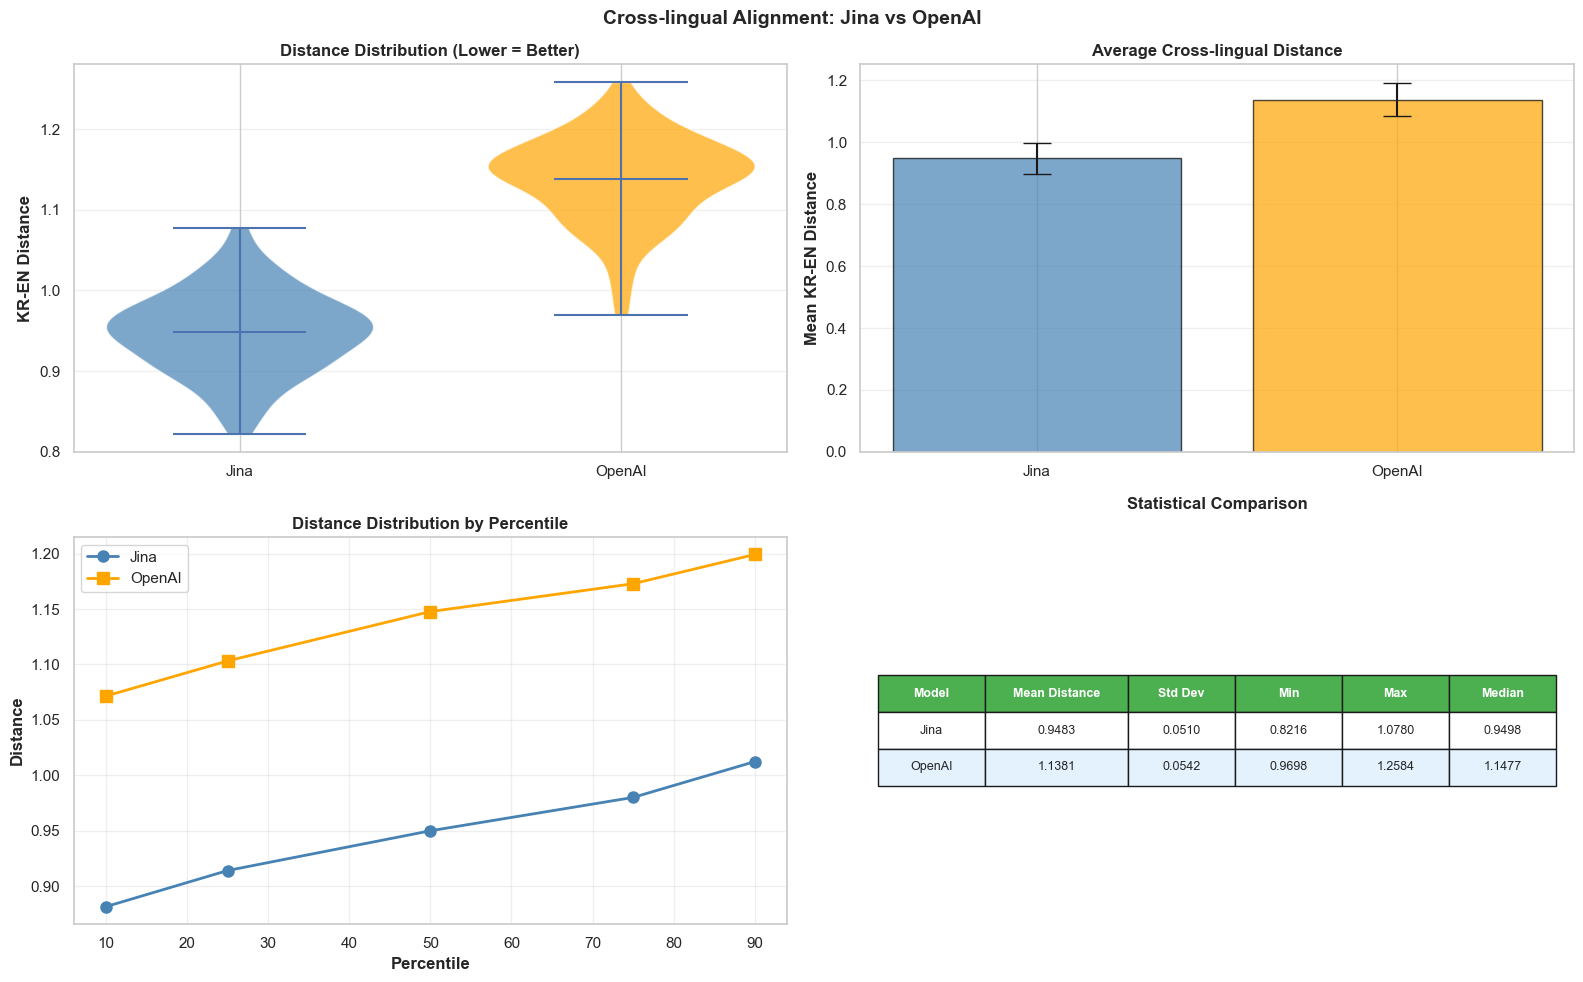


Cross-lingual comparison visualization saved


In [35]:
if has_model_comparison:
    print("\n" + "=" * 80)
    print("CROSS-LINGUAL ALIGNMENT: Model Comparison")
    print("=" * 80)
    
    def compute_cross_lingual_distances_simple(bj_embs, lc_embs, max_pairs=100):
        """Compute KR-EN distances"""
        if bj_embs is None or lc_embs is None:
            return np.array([])
        
        n_pairs = min(len(bj_embs), len(lc_embs), max_pairs)
        distances = []
        
        for i in range(n_pairs):
            dist = np.linalg.norm(bj_embs[i] - lc_embs[i])
            distances.append(dist)
        
        return np.array(distances)
    
    jina_cl_dist = compute_cross_lingual_distances_simple(bj_emb_jina, lc_emb_jina)
    openai_cl_dist = compute_cross_lingual_distances_simple(bj_emb_openai, lc_emb_openai)
    
    print(f"\nJina KR-EN distance:   mean={jina_cl_dist.mean():.4f} +/- {jina_cl_dist.std():.4f}")
    print(f"OpenAI KR-EN distance: mean={openai_cl_dist.mean():.4f} +/- {openai_cl_dist.std():.4f}")
    
    improvement = ((jina_cl_dist.mean() - openai_cl_dist.mean()) / jina_cl_dist.mean()) * 100
    print(f"\nOpenAI improvement over Jina: {improvement:.2f}%")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle("Cross-lingual Alignment: Jina vs OpenAI", fontsize=14, fontweight='bold')
    
    ax = axes[0, 0]
    data_to_plot = [jina_cl_dist, openai_cl_dist]
    positions = [1, 2]
    parts = ax.violinplot(data_to_plot, positions=positions, widths=0.7, showmeans=True, showextrema=True)
    
    for i, pc in enumerate(parts['bodies']):
        colors = ['steelblue', 'orange']
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(['Jina', 'OpenAI'])
    ax.set_ylabel('KR-EN Distance', fontweight='bold')
    ax.set_title('Distance Distribution (Lower = Better)', fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    
    ax = axes[0, 1]
    means = [jina_cl_dist.mean(), openai_cl_dist.mean()]
    stds = [jina_cl_dist.std(), openai_cl_dist.std()]
    models = ['Jina', 'OpenAI']
    
    ax.bar(models, means, yerr=stds, capsize=10, color=['steelblue', 'orange'], alpha=0.7, edgecolor='black')
    ax.set_ylabel('Mean KR-EN Distance', fontweight='bold')
    ax.set_title('Average Cross-lingual Distance', fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    
    ax = axes[1, 0]
    percentiles = [10, 25, 50, 75, 90]
    
    jina_values = [np.percentile(jina_cl_dist, p) for p in percentiles]
    openai_values = [np.percentile(openai_cl_dist, p) for p in percentiles]
    
    ax.plot(percentiles, jina_values, 'o-', label='Jina', linewidth=2, markersize=8, color='steelblue')
    ax.plot(percentiles, openai_values, 's-', label='OpenAI', linewidth=2, markersize=8, color='orange')
    ax.set_xlabel('Percentile', fontweight='bold')
    ax.set_ylabel('Distance', fontweight='bold')
    ax.set_title('Distance Distribution by Percentile', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    ax = axes[1, 1]
    comparison_data = {
        'Model': ['Jina', 'OpenAI'],
        'Mean Distance': [f"{jina_cl_dist.mean():.4f}", f"{openai_cl_dist.mean():.4f}"],
        'Std Dev': [f"{jina_cl_dist.std():.4f}", f"{openai_cl_dist.std():.4f}"],
        'Min': [f"{jina_cl_dist.min():.4f}", f"{openai_cl_dist.min():.4f}"],
        'Max': [f"{jina_cl_dist.max():.4f}", f"{openai_cl_dist.max():.4f}"],
        'Median': [f"{np.median(jina_cl_dist):.4f}", f"{np.median(openai_cl_dist):.4f}"]
    }
    
    df_comp = pd.DataFrame(comparison_data)
    
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df_comp.values, colLabels=df_comp.columns,
                    cellLoc='center', loc='center', colWidths=[0.15, 0.2, 0.15, 0.15, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    for i in range(len(df_comp.columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    for i in range(1, len(df_comp) + 1):
        color = '#E3F2FD' if i % 2 == 0 else 'white'
        for j in range(len(df_comp.columns)):
            table[(i, j)].set_facecolor(color)
    
    ax.set_title('Statistical Comparison', fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(f"{IMG_DIR}/cross_lingual_comparison_jina_vs_openai.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nCross-lingual comparison visualization saved")
    print("=" * 80)
else:
    print("\nSkipping cross-lingual comparison (embeddings not available)")